In [1]:
import yaml
from pathlib import Path

with open(r"C:\Users\Admin\Documents\GAMBLING PROJECT\config\settings.yaml") as f:
    cfg = yaml.safe_load(f)

EXPORT_DIR_HSE = Path(r"C:\Users\Admin\Documents\GAMBLING PROJECT") / cfg["outputs"]["hse_exports"]
EXPORT_DIR_HSE.mkdir(parents=True, exist_ok=True)

EXPORT_DIR_GSGB = Path(r"C:\Users\Admin\Documents\GAMBLING PROJECT") / cfg["outputs"]["gsgb_exports"]
EXPORT_DIR_GSGB.mkdir(parents=True, exist_ok=True)

print("UKHLS Export directory created at:", EXPORT_DIR_HSE)
print("GSGB Export directory created at:", EXPORT_DIR_GSGB)

UKHLS Export directory created at: C:\Users\Admin\Documents\GAMBLING PROJECT\outputs\hse_exports
GSGB Export directory created at: C:\Users\Admin\Documents\GAMBLING PROJECT\outputs\gsgb_exports


LOAD REQUIRED PACKAGES AND LIBRARIES

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from sklearn.experimental import enable_iterative_imputer # For missing data imputation
from sklearn.impute import IterativeImputer #for missing data imputation

import os #for file path operations

#import packages for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import joblib #for saving models

import shap


In [ ]:
# Show full columns in previews
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', True)
pd.reset_option("display.float_format")

os.getcwd()

os.chdir(r"C:\Users\Admin\Documents\GAMBLING PROJECT")

Read the data (HSE 2021)

In [ ]:
os.chdir(r"C:\Users\Admin\Documents\GAMBLING PROJECT\dataset\raw\Health survey for England\HSE_2021")
hse_2021 = pd.read_stata("hse_2021.dta", convert_categoricals=False)
hse_2021.shape
hse_2021.head(10)


Seriala  FinOutc  Qrtint  intdayw  HSEYR  IndOut  SampType  LiveWith  \
0  31003611      110       1        4   2021     110         1         2   
1  31005079      110       1        2   2021     110         1         2   
2  31004979      110       1        7   2021     110         1         2   
3  31008646      110       1        7   2021     110         1         2   
4  31003282      110       1        3   2021     110         1         2   
5  31004865      110       1        3   2021     110         1         2   
6  31000281      110       1        3   2021     110         1         2   
7  31002354      110       1        1   2021     110         1         2   
8  31001096      110       1        1   2021     110         1         2   
9  31007615      110       1        5   2021     110         1         2   

   tenureb  JobAccom  LandLord  furn  Car  NumCars  srcin01d  srcin02d  \
0        3         2         2    -8    2       -1         1         0   
1        4         2         2     3    1        1         1         0   
2        1        -1        -1    -1    1        1         1         1   
3        1        -1        -1    -1    1        1         1         1   
4        1        -1        -1    -1    1        1         0         1   
5        1        -1        -1    -1    1        2         0         1   
6        1        -1        -1    -1    1        2         0         1   
7        1        -1        -1    -1    1        3         1         0   
8        1        -1        -1    -1    1        3         1         0   
9        1        -1        -1    -1    1        2         0         1   

   srcin03d  srcin04d  srcin05d  srcin06d  srcin07d  srcin08d  srcin09d  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         1         0         0         0         0         0         0   
3         1         0         0         0         0         0         0   
4         1         1         0         0         0         0         0   
5         0         1         0         0         0         0         0   
6         0         1         0         0         0         0         0   
7         0         0         0         0         0         0         0   
8         0         0         0         0         0         0         0   
9         1         0         0         0         0         0         0   

   srcin10d  srcin11d  srcin12d  srcin13d  srcin14d  srcin15d  srcin16d  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         1   
3         0         0         0         0         0         0         1   
4         0         0         0         0         0         0         0   
5         0         0         0         0         0         0         1   
6         0         0         0         0         0         0         1   
7         0         0         0         0         0         0         0   
8         0         0         0         0         0         0         0   
9         0         0         0         0         0         0         1   

   srcin17d  AttDisb1  AttDisb2  AttDisb3  AttDisb4  AttDisb5  AttDisb96  \
0         0         0         0         0         0         0          1   
1         0         0         0         0         0         0          1   
2         0         0         0         0         0         0          1   
3         0         0         0         0         0         0          1   
4         0         0         0         0         0         0          1   
5         0         0         0         0         0         0          1   
6         0         0         0         0         0         0          1   
7         0         0         0         0         0         0          1   
8         0     

select the columns of interest in HSE 2021

In [ ]:
#serial number
Serial_number_2021 = [hse_2021['Seriala'].name]

hse_2021_year = [hse_2021['HSEYR'].name]  # year variable 

#gambling (PGSI) variables
hse_2021_pgsi = [
    hse_2021['PGSIPROB'].name,
    hse_2021['PGSIsc'].name
]

# #Mental health (GHQ) variables
# ghq2_col = [hse_2021['GHQ12Scr'].name]

#common demographic variable names
hse_2021_demo = [
    hse_2021['Sex'].name,
    hse_2021['ag16g10'].name,
    hse_2021['Educ2'].name
]

#region variable
hse_2021_region = [hse_2021['GOR1'].name]

# Gambling activity variables
hse_2021_gambling_activity = [hse_2021['onlinegam'].name]     

# combine all groups
hse_2021_combine = Serial_number_2021 + hse_2021_year + hse_2021_pgsi + hse_2021_demo + hse_2021_region + hse_2021_gambling_activity

# Keep only those that actually exist in the file (safe filtering)
# keep_cols2 = [c for c in keep_cols if c in hse_2021.columns]

# selected  columns
hse_2021_selected_columns = hse_2021[hse_2021_combine].copy()
print("shape: ", hse_2021_selected_columns.shape)
hse_2021_selected_columns.head(10)

shape:  (7120, 9)


,Seriala,HSEYR,PGSIPROB,PGSIsc,Sex,ag16g10,Educ2,GOR1,onlinegam
0,31003611,2021,-1,-1,2,5,2,7,-1
1,31005079,2021,0,0,1,5,3,7,2
2,31004979,2021,0,0,1,6,1,8,2
3,31008646,2021,0,0,2,6,2,8,2
4,31003282,2021,0,0,2,6,1,8,2
5,31004865,2021,0,0,1,6,2,8,2
6,31000281,2021,-9,-9,2,6,2,8,2
7,31002354,2021,-9,-9,2,5,1,8,2
8,31001096,2021,0,0,1,5,1,8,2
9,31007615,2021,0,0,1,7,2,8,2


In [ ]:
#Save selected columns and dataframe to csv

#saved columns
pd.DataFrame({'column': hse_2021_combine}).to_csv(EXPORT_DIR_HSE / "hse_2021_columns.csv", index=False)

#saved dataframe
hse_2021_selected_columns.to_csv(EXPORT_DIR_HSE / "hse_2021_selected_columns.csv", index=False)


Read the dataset (HSE_2018)

In [ ]:
os.chdir(r"C:\Users\Admin\Documents\GAMBLING PROJECT\dataset\raw\Health survey for England\HSE_2018")
hse_2018 = pd.read_stata("hse_2018.dta", convert_categoricals=False)
hse_2018.shape
hse_2018.head(10)


Seriala  HSEYr  SampType  FinOutc  hhsize6  Nofad3  Nofch3  Qrtint  \
0  2811527   2018         1      110        1       1       0       1   
1  2804238   2018         1      110        1       1       0       1   
2  2808193   2018         1      110        2       2       0       1   
3  2807643   2018         1      110        2       2       0       1   
4  2803796   2018         1      110        3       2       1       1   
5  2806132   2018         1      110        3       2       1       1   
6  2809499   2018         1      110        3       2       1       1   
7  2804411   2018         1      110        4       3       1       1   
8  2811218   2018         1      110        4       3       1       1   
9  2806649   2018         1      110        4       3       1       1   

   intdayw  IndOut  Sex  ag16g10  age16g5  Age35g  Ag015g4  marstatD  couple2  \
0        6     110    2        6       12      17       -1         5       -1   
1        5     110    1        6       12      17       -1         5       -1   
2        2     110    1        5       11      16       -1         2       -1   
3        2     110    2        5       11      16       -1         2       -1   
4        3     110    1        4        9      14       -1         2       -1   
5        3     110    2        4        8      13       -1         2       -1   
6        3     110    1       -1       -1       4        2        -1       -1   
7        2     110    1        4        8      13       -1         2       -1   
8        2     110    2        4        8      13       -1         2       -1   
9        2     110    2       -1       -1       6        3        -1       -1   

   LiveWith  tenureb  JobAccom  LandLord  furn  bedrooms6  PasSm  NumSm  Car  \
0         2        1        -1        -1    -1          3      1      1    2   
1         2        1        -1        -1    -1          4      2     -1    1   
2         2        1        -1        -1    -1          4      2     -1    1   
3         2        1        -1        -1    -1          4      2     -1    1   
4         2        2        -1        -1    -1          3      2     -1    1   
5         2        2        -1        -1    -1          3      2     -1    1   
6         2        2        -1        -1    -1          3      2     -1    1   
7         2        1        -1        -1    -1          4      2     -1    1   
8         2        1        -1        -1    -1          4      2     -1    1   
9         2        1        -1        -1    -1          4      2     -1    1   

   NumCars  srcin01d  srcin02d  srcin03d  srcin04d  srcin05d  srcin06d  \
0       -1         0         1         1         0         0         0   
1        1         0         1         1         0         0         0   
2        2         1         0         1         0         0         0   
3        2         1         0         1         0         0         0   
4        2         1         0         0         0         0         0   
5        2         1         0         0         0         0         0   
6        2         1         0         0         0         0         0   
7        1         1         0         0         0         0         0   
8        1         1         0         0         0         0         0   
9        1         1         0         0         0         0         0   

   srcin07d  srcin08d  srcin09d  srcin10d  srcin11d  srcin12d  srcin13d  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         1         0         0   
5         0         0         0         0         1         0         0   
6         0         0         0         0         1         0         0   
7         0

In [ ]:
hse_2018.to_csv(EXPORT_DIR_HSE / "hse_2018.csv", index=False)

Select the columns of interest in HSE 2018

In [ ]:
#serial number
Serial_number_2018 = [hse_2018['Seriala'].name]

hse_2018_year = [hse_2018['HSEYr'].name]  # year variable 

#gambling (PGSI) variables
hse_2018_pgsi = [
    hse_2018['PGSIPROB'].name,
    hse_2018['PGSIsc'].name
]


#common demographic variable names
hse_2018_demo = [
    hse_2018['Sex'].name,
    hse_2018['ag16g10'].name,
    hse_2018['Educ2'].name
]

#region variable
hse_2018_region = [hse_2018['GOR1'].name]

# Gambling activity variables
hse_2018_gambling_activity = [hse_2018['onlinegam'].name]     


# combine all groups
hse_2018_combine = Serial_number_2018 + hse_2018_year + hse_2018_pgsi + hse_2018_demo + hse_2018_region + hse_2018_gambling_activity

# Keep only those that actually exist in the file (safe filtering)
# keep_cols2 = [c for c in keep_cols if c in hse_2018.columns]

# selected  columns
hse_2018_selected_columns = hse_2018[hse_2018_combine].copy()
print("shape: ", hse_2018_selected_columns.shape)
hse_2018_selected_columns.head(10)

shape:  (10250, 9)


,Seriala,HSEYr,PGSIPROB,PGSIsc,Sex,ag16g10,Educ2,GOR1,onlinegam
0,2811527,2018,0,0,2,6,2,7,-9
1,2804238,2018,0,0,1,6,1,7,2
2,2808193,2018,0,0,1,5,2,7,2
3,2807643,2018,0,0,2,5,1,7,2
4,2803796,2018,0,0,1,4,1,7,1
5,2806132,2018,-9,-9,2,4,1,7,-9
6,2809499,2018,-1,-1,1,-1,-1,7,-1
7,2804411,2018,0,0,1,4,2,7,2
8,2811218,2018,0,0,2,4,2,7,2
9,2806649,2018,-1,-1,2,-1,-1,7,-1


In [ ]:
#Save selected columns and dataframe to csv

#saved columns
pd.DataFrame({'column': hse_2018_combine}).to_csv(EXPORT_DIR_HSE / "hse_2018_columns.csv", index=False)

#saved dataframe
hse_2018_selected_columns.to_csv(EXPORT_DIR_HSE / "hse_2018_selected_columns.csv", index=False)

Read the Gambling Survey for Great Britain (GSGB)(2023)

In [ ]:
os.chdir(r"C:\Users\Admin\Documents\GAMBLING PROJECT\dataset\raw\Gambling survey for great Britain")
gsgb_2023  = pd.read_stata("gsgb_year_1_2023.dta", convert_categoricals=False)
gsgb_2023.shape
gsgb_2023.head(10)

,mode,SerialA,QuarterN,LeisureAct_FriendsFamily_q,LeisureAct_Read_q,LeisureAct_ListenMusic_q,LeisureAct_WatchTV_q,LeisureAct_Restaurants_q,LeisureAct_PubBarClub_q,LeisureAct_DIYGarden_q,LeisureAct_GoShopping_q,LeisureAct_SportsExer_q,LeisureAct_ArtsCrafts_q,LeisureAct_PlayInstrument_q,LeisureAct_CinemaTheatre_q,LeisureAct_MuseumGallery_q,LeisureAct_ReligiousServ_q,IntPurposeExpY01,IntPurposeExpY02,IntPurposeExpY03,IntPurposeExpY04,IntPurposeExpY05,IntPurposeExpY06,IntPurposeExpY07,IntPurposeExpY08,IntPurposeExpY09,IntPurposeExpY10,IntPurposeExpY11,IntPurposeExpY12,gambpartyear_final001,gambpartyear_final002,gambpartyear_final003,gambpartyear_final004,gambpartyear_final005,gambpartyear_final006,gambpartyear_final007,gambpartyear_final008,gambpartyear_final009,gambpartyear_final010,gambpartyear_final011,gambpartyear_final012,gambpartyear_final013,gambpartyear_final014,gambpartyear_final015,gambpartyear_final016,gambpartyear_final017,gambpartyear_final018,gambpartyear_final019,gambpartyear_final906,gambpartyear_final907,gambpartyear_final908,gambpartyear_final909,gambpartyear_final920,gambpartyear_final930,GambledPastYearDV,GambFeelExpYLastOccassion,ReasonsGambleQuestionnaire_MBigm,ReasonsGambleQuestionnaire_MFun_,ReasonsGambleQuestionnaire_MHobb,ReasonsGambleQuestionnaire_MEsca,ReasonsGambleQuestionnaire_MWorr,ReasonsGambleQuestionnaire_MComp,ReasonsGambleQuestionnaire_MExci,ReasonsGambleQuestionnaire_MChal,ReasonsGambleQuestionnaire_MAchi,ReasonsGambleQuestionnaire_MImpr,ReasonsGambleQuestionnaire_MSoci,ReasonsGambleQuestionnaire_MTens,ReasonsGambleQuestionnaire_MMone,ReasonsGambleQuestionnaire_MRela,ReasonsGambleQuestionnaire_MFami,Typologies_TYPenjoy_q,Typologies_TPYconf_q,Typologies_TYPfam_q,Typologies_TYPfree_q,Typologies_TYPchance_q,Typologies_TYPnoidea_q,Typologies_TYPrisk_q,Typologies_TYPcomp_q,Typologies_TYPme_q,Typologies_TYPlong_q,Typologies_TYPstars_q,Typologies_TYPenjfam_q,Typologies_TYPalways_q,Typologies_TYPhunch_q,Typologies_TYPprove_q,Typologies_TYPdowell_q,Typologies_TYPsolo_q,Binge1,Binge2,Binge3_WhileGamb_q,Binge3_AfterGamb_q,Binge401,Binge402,Binge403,Binge404,Binge405,Binge406,Binge407,Binge408,Binge409,Binge410,Binge411,Binge412,Binge413,Binge414,Binge415,Binge416,Binge417,Binge418,Binge419,Binge420,Binge421,Binge422,GambManageToolsAware01,GambManageToolsAware02,GambManageToolsAware03,GambManageToolsAware04,GambManageToolsAware05,GambManageToolsAware06,GambManageToolsAware07,GambManageToolsAware08,GambManageToolsAware09,GambReduce,GambManageToolsUse01,GambManageToolsUse02,GambManageToolsUse03,GambManageToolsUse04,GambManageToolsUse05,GambManageToolsUse06,GambManageToolsUse07,GambManageToolsUse08,GambManageToolsUse09,p1,p2,p3,p4,p5,p6,p7,p8,p9,GambOwnConseqDV_PGSI_Afford,GambOwnConseqDV_PGSI_Larger,GambOwnConseqDV_PGSI_WinBack,GambOwnConseqDV_PGSI_Borrow,GambOwnConseqDV_PGSI_Problem,GambOwnConseqDV_PGSI_Health,GambOwnConseqDV_PGSI_Told,GambOwnConseqDV_PGSI_Financial,GambOwnConseqDV_PGSI_Guilty,PGSISC,PGSIPROB,PGSIGR2,Conseq_own_PotAdv1,Conseq_own_PotAdv2,Conseq_own_PotAdv3,Conseq_own_PotAdv4,Conseq_own_PotAdv5,Conseq_own_PotAdv6,Conseq_own_SevereAdv1,Conseq_own_SevereAdv2,Conseq_own_SevereAdv3,Conseq_own_SevereAdv4,Conseq_own_services1,Conseq_own_services2,Conseq_own_services3,Conseq_own_services4,LotteryTickets4weeks_NLotteryOnl,LotteryTickets4weeks_NLotteryInP,LotteryTickets4weeks_OtherCharit,LotteryTickets4weeks_OtherChari0,LotteryTickets4weeks_NLotteryOn0,LotteryTickets4weeks_NLotteryIn0,LotteryTickets4weeks_OtherChari1,LotteryTickets4weeks_OtherChari2,LotteryTickets4weeks_NLotteryOn1,LotteryTickets4weeks_NLotteryIn1,LotteryTickets4weeks_OtherChari3,LotteryTickets4weeks_OtherChari4,ScratchcardInstantWin4weeks_NLot,ScratchcardInstantWin4weeks_Othe,ScratchcardInstantWin4weeks_NLo0,ScratchcardInstantWin4weeks_Oth0,ScratchcardInstantWin4weeks_NLo1,ScratchcardInstantWin4weeks_Oth1,ScratchcardInstantWin4weeks_NLo2,ScratchcardInstantWin4weeks_Oth2,ScratchcardInstantWin4weeks_NLo3,ScratchcardInstantWin4weeks_Ot

In [ ]:
gsgb_2023.to_csv(EXPORT_DIR_GSGB / "gsgb_2023.csv", index=False)

Select the columns of interest in GSGB (2023)

In [ ]:
#serial number
Serial_number_2023 = [gsgb_2023['SerialA'].name]

#add year variable to gsgp data

#gambling (PGSI) variables
gsgb_2023_ppgsi= [
    gsgb_2023['PGSIPROB'].name,
    gsgb_2023['PGSISC'].name
]

#common demographic variable names
gsgb_2023_demo = [
    gsgb_2023['Sex'].name,
    gsgb_2023['DvageG'].name,
    gsgb_2023['EducationDV'].name
]

#region variable
gsgb_2023_region = [gsgb_2023['GOR_DV'].name]

# Gambling activity variables
gsgb_2023_gambling_activity = [gsgb_2023['onlinegam'].name]     


# combine all groups
gsgp_2023_combine = Serial_number_2023 + gsgb_2023_ppgsi + gsgb_2023_demo + gsgb_2023_region + gsgb_2023_gambling_activity

# Keep only those that actually exist in the file (safe filtering)
# keep_cols2 = [c for c in keep_cols if c in hse_2018.columns]

# selected  columns
gsgb_2023_selected_columns = gsgb_2023[gsgp_2023_combine].copy()
print("shape: ", gsgb_2023_selected_columns.shape)
gsgb_2023_selected_columns.head(10)

shape:  (9742, 8)


,SerialA,PGSIPROB,PGSISC,Sex,DvageG,EducationDV,GOR_DV,onlinegam
0,10048739,1,0,1,2,3,1,1
1,10014118,1,0,2,3,1,1,1
2,10033673,0,0,2,6,3,1,2
3,10020646,0,0,1,7,1,1,2
4,10043979,0,0,2,2,2,1,2
5,10071182,1,0,1,2,3,1,1
6,10024066,0,0,2,5,2,1,2
7,10049333,0,0,2,1,2,1,2
8,10038819,0,0,2,6,3,1,2
9,10058269,1,0,2,6,3,1,2


In [ ]:
#add gsgb_year variable to gsgp data
gsgb_2023_selected_columns['gsgb_year'] = 2023

move_gsgb_year = gsgb_2023_selected_columns.pop('gsgb_year')  # removes it from the df and stores its data
gsgb_2023_selected_columns.insert(loc=1, column='gsgb_year', value= move_gsgb_year)  # Insert it back at index location 0 (the first position)
gsgb_2023_selected_columns.shape
gsgb_2023_selected_columns

,SerialA,gsgb_year,PGSIPROB,PGSISC,Sex,DvageG,EducationDV,GOR_DV,onlinegam
0,10048739,2023,1,0,1,2,3,1,1
1,10014118,2023,1,0,2,3,1,1,1
2,10033673,2023,0,0,2,6,3,1,2
3,10020646,2023,0,0,1,7,1,1,2
4,10043979,2023,0,0,2,2,2,1,2
...,...,...,...,...,...,...,...,...,...
9737,10000062,2023,1,0,2,7,1,11,2
9738,10070749,2023,1,0,1,7,2,11,2
9739,10016378,2023,0,0,2,4,3,11,2
9740,10069245,2023,0,0,1,6,2,11,2


In [ ]:
gsgb_2023_selected_columns.to_csv(EXPORT_DIR_GSGB / "gsgb_2023_selected_columns.csv", index=False)

Rename the columns

In [ ]:
hse_2018_selected_columns = hse_2018_selected_columns.rename(columns={
    "Seriala": "Serial_no",
    "HSEYr": "survey_year",
    "PGSIPROB": "pgsi_category",
    "PGSIsc": "pgsi_score",
    "Sex": "sex",
    "ag16g10": "age_group",
    "Educ2": "education",
    "GOR1": "region",
    "onlinegam": "online_gambling"
   
})

hse_2021_selected_columns = hse_2021_selected_columns.rename(columns={
    "Seriala": "Serial_no",
    "HSEYR": "survey_year",
    "PGSIPROB": "pgsi_category",
    "PGSIsc": "pgsi_score",
    "Sex": "sex",
    "ag16g10": "age_group",
    "Educ2": "education",
    "GOR1": "region",
    "onlinegam": "online_gambling"
})

gsgb_2023_selected_columns = gsgb_2023_selected_columns.rename(columns={
    "SerialA": "Serial_no",
    "gsgb_year": "survey_year",
    "PGSIPROB": "pgsi_category",
    "PGSISC": "pgsi_score",
    "Sex": "sex",
    "DvageG": "age_group",
    "EducationDV": "education",
    "GOR_DV": "region",
    "onlinegam": "online_gambling",
})


In [ ]:
gsgb_2023.shape

(9742, 458)

Handling negative values in the dataset

In [ ]:

# Define negative codes
neg_codes = [-1, -2, -7, -8, -9]

hse_2018_replaced_neg = hse_2018_selected_columns.replace(neg_codes, np.nan)
hse_2021_replaced_neg = hse_2021_selected_columns.replace(neg_codes, np.nan)
gsgb_2023_replaced_neg = gsgb_2023_selected_columns.replace(neg_codes, np.nan)

print(hse_2018_replaced_neg.shape)
print(hse_2021_replaced_neg.shape)
print(gsgb_2023_replaced_neg.shape)


hse_2018_replaced_neg.to_csv(EXPORT_DIR_HSE / "hse_2018_replaced_neg.csv", index=False)
hse_2021_replaced_neg.to_csv(EXPORT_DIR_HSE / "hse_2021_replaced_neg.csv", index=False)
gsgb_2023_replaced_neg.to_csv(EXPORT_DIR_GSGB / "gsgb_2023_replaced_neg.csv", index=False)

(10250, 9)
(7120, 9)
(9742, 9)


Check for missing value

In [ ]:
print("Missing values summary for each dataset:")
missing_summary = pd.concat(
    [
        hse_2018_replaced_neg.isnull().sum().rename("HSE 2018"),
        hse_2021_replaced_neg.isnull().sum().rename("HSE 2021"),
        gsgb_2023_replaced_neg.isnull().sum().rename("GSGB 2023"),
    ],
    axis=1
)
print(missing_summary)

Missing values summary for each dataset:
                 HSE 2018  HSE 2021  GSGB 2023
Serial_no               0         0          0
survey_year             0         0          0
pgsi_category        3327      3547        109
pgsi_score           3327      3547         46
sex                     0         0         17
age_group            2072      1240          3
education            2116      1276        220
region                  0         0          0
online_gambling      3072      3302        151


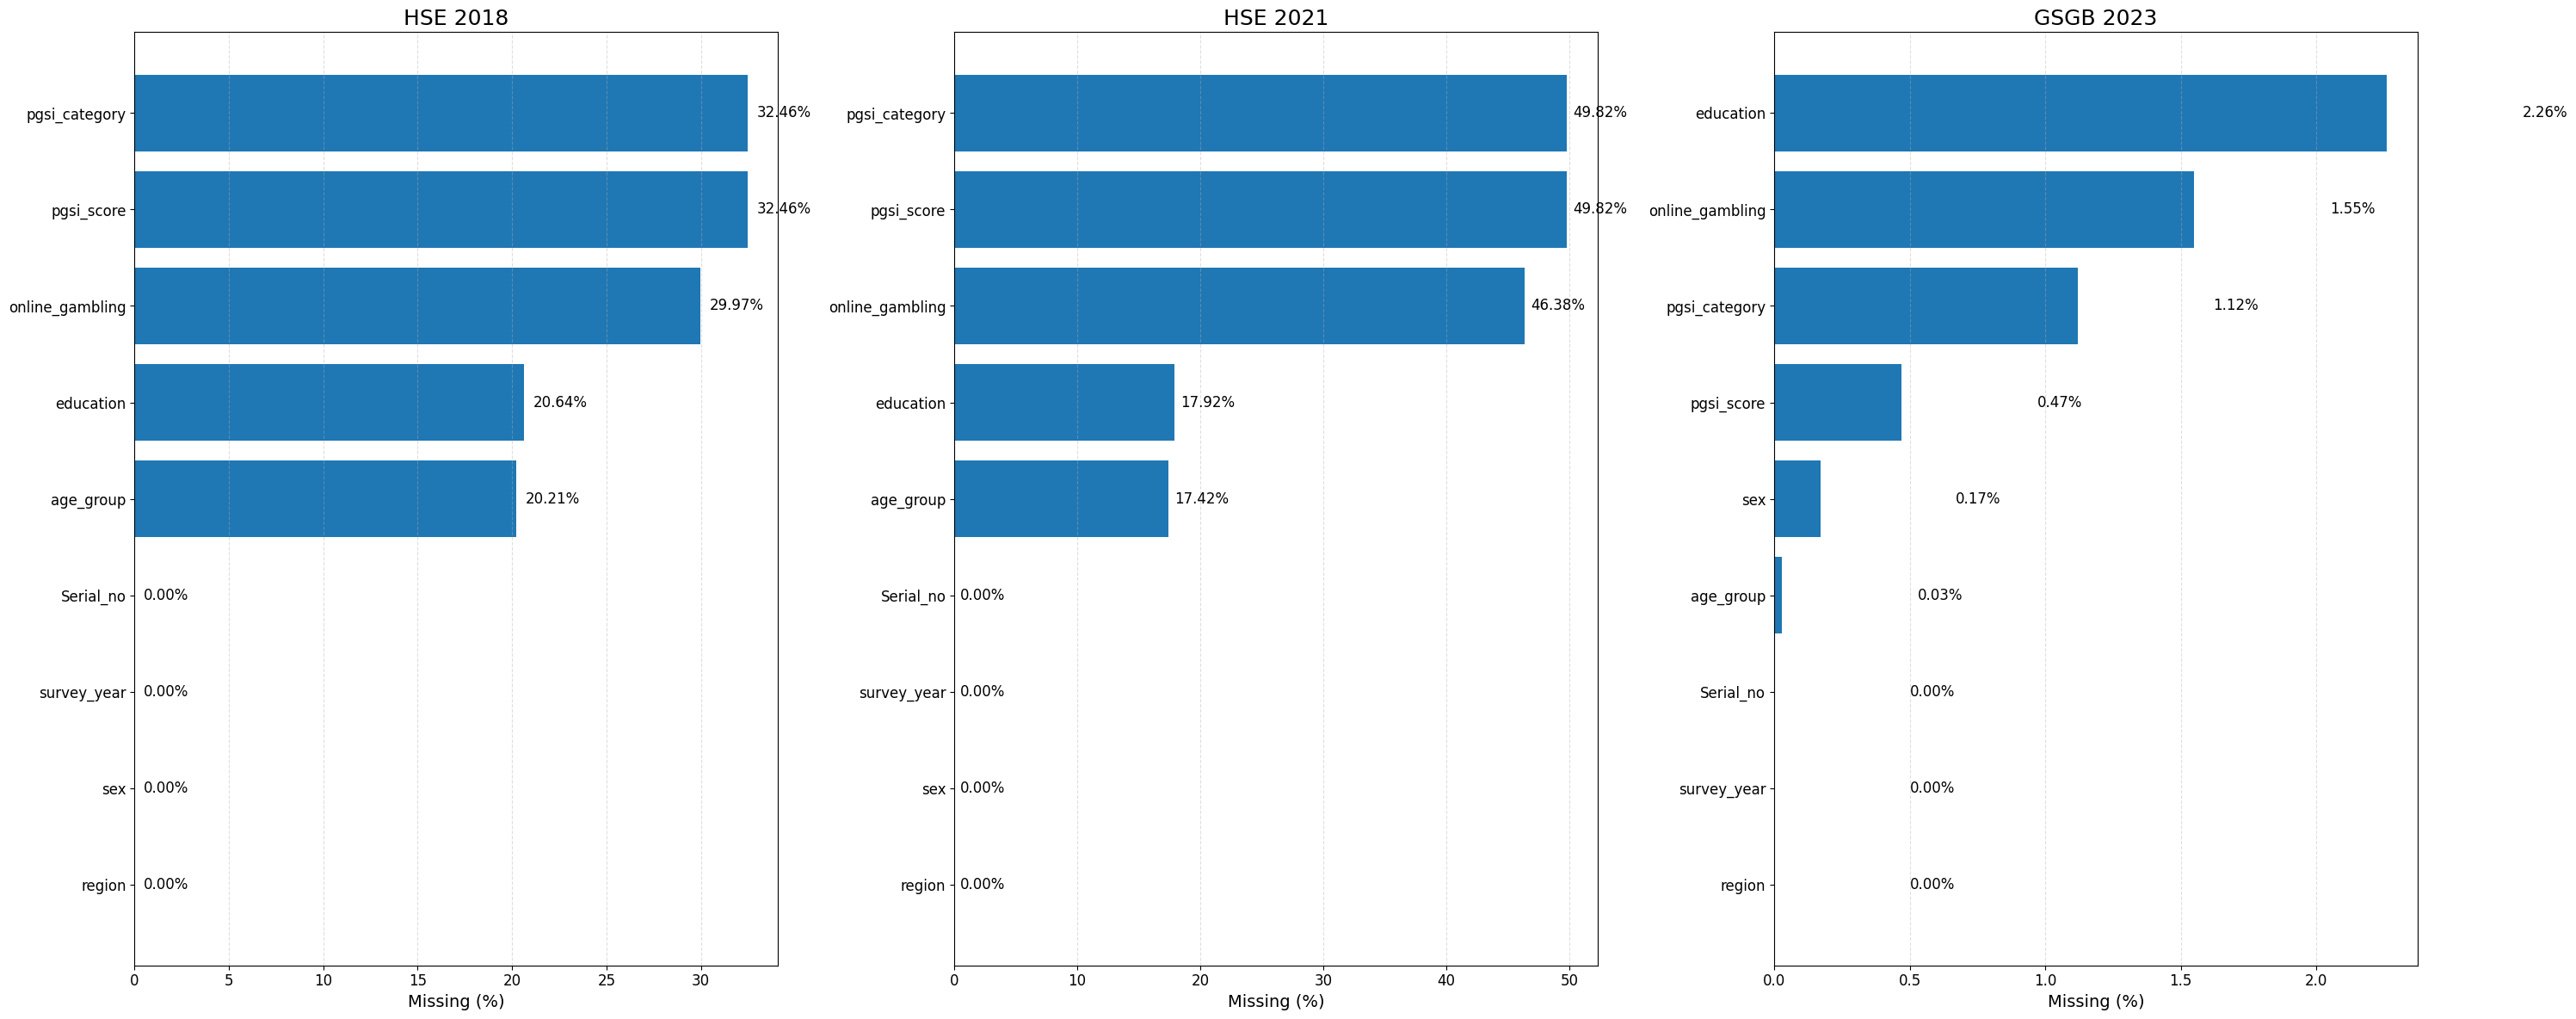

In [ ]:
# Visualize percentage of missing values

def plot_missing_barh(ax, df, title):
    missing_percent = (df.isna().sum() / len(df) * 100).round(2)
    missing_df = missing_percent.sort_values(ascending=False).to_frame(name="Missing_Percent")

    ax.barh(
        missing_df.index,
        missing_df["Missing_Percent"],
        color="#1f77b4"  # default blue, clean on white
    )
    ax.invert_yaxis()

    # Add text labels
    for i, value in enumerate(missing_df["Missing_Percent"]):
        ax.text(
            value + 0.5,
            i,
            f"{value:.2f}%",
            va="center",
            ha="left",
            fontsize=12,
            color="black"
        )

    ax.set_title(title, fontsize=18, color="black")
    ax.set_xlabel("Missing (%)", fontsize=14, color="black")
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    # Optional: keep spines clean
    for spine in ax.spines.values():
        spine.set_color("black")

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "font.size": 12
})

fig, axes = plt.subplots(1, 3, figsize=(30, 12))

plot_missing_barh(axes[0], hse_2018_replaced_neg, "HSE 2018")
plot_missing_barh(axes[1], hse_2021_replaced_neg, "HSE 2021")
plot_missing_barh(axes[2], gsgb_2023_replaced_neg, "GSGB 2023")

plt.tight_layout()
plt.show()

Handle missing values

In [ ]:

#load the the dataset (dataset Replaced with Nan for the negative codes)  
paths = {
    "hse_2018": r"C:\Users\Admin\Documents\gambling project\outputs\hse_exports\hse_2018_replaced_neg.csv",
    "hse_2021": r"C:\Users\Admin\Documents\gambling project\outputs\hse_exports\hse_2021_replaced_neg.csv",
    "gsgb_2023": r"C:\Users\Admin\Documents\gambling project\outputs\gsgb_exports\gsgb_2023_replaced_neg.csv"
}
cleaned = {}

def preprocess(df):
    df = df.copy()

    # Identify gambling-related column
    gamble_cols = [c for c in df.columns if any(x in c.lower() for x in ["gam"])]
    df["gambled"] = df[gamble_cols].fillna(0).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

    # Logical PGSI fill
    for pg in ["pgsi_category", "pgsi_score"]:
        if pg in df.columns:
            df.loc[df["gambled"] == 0, pg] = 0

    # Replace missing categorical with Unknown
    for col in ["sex", "education", "age_group", "region", "online_gambling"]:
        if col in df.columns:
            df[col] = df[col].astype("object").fillna("Unknown")
    return df

def mice_pgsi(df):
    df = df.copy()

    # Columns to impute
    pgsi_cols = [c for c in ["pgsi_category", "pgsi_score"] if c in df.columns]

    if not pgsi_cols:
        return df

    # Only gamblers can have missing PGSI
    mask = df["gambled"] == 1
    df_subset = df.loc[mask, pgsi_cols].copy()

    # Convert to float for imputer
    df_subset = df_subset.astype(float)

    # MICE Imputer
    imputer = IterativeImputer(random_state=42)
    df.loc[mask, pgsi_cols] = imputer.fit_transform(df_subset)

    return df

# Apply the pipeline
final = {}
for name, path in paths.items():
    df = pd.read_csv(path)
    df_clean = preprocess(df)
    df_imputed = mice_pgsi(df_clean)
    cleaned[name] = df_imputed


Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Down

In [ ]:
# cleaned["gsgb_2023"].isna().sum()
cleaned["hse_2018"]

,Serial_no,survey_year,pgsi_category,pgsi_score,sex,age_group,education,region,online_gambling,gambled
0,2811527,2018,0.0,0.0,2,6.0,2.0,7,Unknown,0
1,2804238,2018,0.0,0.0,1,6.0,1.0,7,2.0,1
2,2808193,2018,0.0,0.0,1,5.0,2.0,7,2.0,1
3,2807643,2018,0.0,0.0,2,5.0,1.0,7,2.0,1
4,2803796,2018,0.0,0.0,1,4.0,1.0,7,1.0,1
...,...,...,...,...,...,...,...,...,...,...
10245,2807899,2018,0.0,0.0,1,5.0,1.0,6,2.0,1
10246,2811716,2018,0.0,0.0,2,1.0,1.0,6,2.0,1
10247,2805087,2018,0.0,0.0,2,1.0,2.0,6,2.0,1
10248,2803561,2018,0.0,0.0,2,Unknown,Unknown,6,Unknown,0


In [ ]:
# Round PGSI columns
def round_pgsi(df, pgsi_cols=["pgsi_score", "pgsi_category"]):
    df = df.copy()
    for col in pgsi_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").round()
    return df

# Convert  columns to Int64 (removes decimals completely)

def convert_pgsi_to_int(df, pgsi_cols=["pgsi_score", "pgsi_category"]):
    df = df.copy()
    for col in df.columns:
        if col in pgsi_cols:
            df[col] = df[col].astype("Int64")
    return df

#apply the functions
def clean_pgsi(df):
    df = round_pgsi(df)
    df = convert_pgsi_to_int(df)
    return df


hse_2018_clean = clean_pgsi(cleaned["hse_2018"])
hse_2021_clean = clean_pgsi(cleaned["hse_2021"])
gsgb_2023_clean = clean_pgsi(cleaned["gsgb_2023"])



In [ ]:
hse_2018_clean

,Serial_no,survey_year,pgsi_category,pgsi_score,sex,age_group,education,region,online_gambling,gambled
0,2811527,2018,0,0,2,6.0,2.0,7,Unknown,0
1,2804238,2018,0,0,1,6.0,1.0,7,2.0,1
2,2808193,2018,0,0,1,5.0,2.0,7,2.0,1
3,2807643,2018,0,0,2,5.0,1.0,7,2.0,1
4,2803796,2018,0,0,1,4.0,1.0,7,1.0,1
...,...,...,...,...,...,...,...,...,...,...
10245,2807899,2018,0,0,1,5.0,1.0,6,2.0,1
10246,2811716,2018,0,0,2,1.0,1.0,6,2.0,1
10247,2805087,2018,0,0,2,1.0,2.0,6,2.0,1
10248,2803561,2018,0,0,2,Unknown,Unknown,6,Unknown,0


Harmonisation

In [ ]:
# Harmonise Education for HSE
def map_hse_education(x):
    if x == 3:
        return 1   # No qualification
    elif x == 2:
        return 2   # Below degree
    elif x == 1:
        return 3   # Degree
    else:
        return np.nan

hse_2018_clean['education_harmonised'] = hse_2018_clean['education'].apply(map_hse_education)
hse_2021_clean['education_harmonised'] = hse_2021_clean['education'].apply(map_hse_education)

# Harmonise Education for GSGB
def map_gsgb_education(x):
    if x == 1:
        return 1   # No qualification
    elif x == 3:
        return 2   # Below degree
    elif x == 2:
        return 3   # Degree
    else:
        return np.nan

gsgb_2023_clean['education_harmonised'] = gsgb_2023_clean['education'].apply(map_gsgb_education)


In [ ]:

# HARMONISE AGE FOR HSE AND GSGB

#harmonise Age for HSE (ag16g10)
def map_hse_age(x):
    if x in [1, 2, 3, 4, 5, 6, 7]:
        return x
    else:
        return np.nan

# Harmonise Age for GSGB (DvageG)
def map_gsgb_age(x):
    if x in [1, 2, 3, 4, 5, 6, 7]:
        return x
    else:
        return np.nan
    
hse_2018_clean["age_harmonised"] = hse_2018_clean["age_group"].apply(map_hse_age)

hse_2021_clean["age_harmonised"] = hse_2021_clean["age_group"].apply(map_hse_age)

gsgb_2023_clean["age_harmonised"] = gsgb_2023_clean["age_group"].apply(map_gsgb_age)



In [ ]:
# Harmonise PGSI across HSE and GSGB

def map_pgsi(x):

    # Handle missing values
    if pd.isna(x):
        return np.nan

    x = int(x)

    # GSGB Unique Code
    if x == 4:        # Problem gambler (PGSI 8+)
        return 3

    # Common codes for both datasets

    if x == 3:
        return 3        # Problem gambler
    if x == 2:
        return 2        # Moderate risk gambler
    if x == 1:
        return 1        # Low-risk (GSGB) or Low-risk (HSE)

    if x == 0:
        return 0        # Non-gambler / non-problem gambler (both datasets)

    return np.nan #return missing for everything else

hse_2018_clean["pgsi_harmonised"] = (hse_2018_clean["pgsi_category"].apply(map_pgsi))
hse_2021_clean["pgsi_harmonised"] = (hse_2021_clean["pgsi_category"].apply(map_pgsi))
gsgb_2023_clean["pgsi_harmonised"] = (gsgb_2023_clean["pgsi_category"].apply(map_pgsi))

In [ ]:
# Harmonise Sex for HSE and GSGB
def map_sex(x):
    if x == 1:
        return 1   # Male
    elif x == 2:
        return 2   # female
    else:
        return np.nan #missing/invalid repsonse
    
#apply to datasets
hse_2018_clean["sex_harmonised"] = hse_2018_clean["sex"].apply(map_sex)
hse_2021_clean["sex_harmonised"] = hse_2018_clean["sex"].apply(map_sex)
gsgb_2023_clean["sex_harmonised"] = gsgb_2023_clean["sex"].apply(map_sex)

In [ ]:
hse_2018_clean

,Serial_no,survey_year,pgsi_category,pgsi_score,sex,age_group,education,region,online_gambling,gambled,education_harmonised,age_harmonised,pgsi_harmonised,sex_harmonised
0,2811527,2018,0,0,2,6.0,2.0,7,Unknown,0,2.0,6.0,0,2
1,2804238,2018,0,0,1,6.0,1.0,7,2.0,1,3.0,6.0,0,1
2,2808193,2018,0,0,1,5.0,2.0,7,2.0,1,2.0,5.0,0,1
3,2807643,2018,0,0,2,5.0,1.0,7,2.0,1,3.0,5.0,0,2
4,2803796,2018,0,0,1,4.0,1.0,7,1.0,1,3.0,4.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,2807899,2018,0,0,1,5.0,1.0,6,2.0,1,3.0,5.0,0,1
10246,2811716,2018,0,0,2,1.0,1.0,6,2.0,1,3.0,1.0,0,2
10247,2805087,2018,0,0,2,1.0,2.0,6,2.0,1,2.0,1.0,0,2
10248,2803561,2018,0,0,2,Unknown,Unknown,6,Unknown,0,NaN,NaN,0,2


Convert Harmonised variables to Categorical labels

In [ ]:
#categrorical labels

# Education categories
edu_categories = {
    1: "No qualification",
    2: "Below degree",
    3: "Degree or higher"
}

#age labels
age_categories = {
    1: "18-24",
    2: "25-34",
    3: "35-44",
    4: "45-54",
    5: "55-64",
    6: "65-74",
    7: "75+"
}

# PGSI categories
pgsi_categories = {
    0: "Non-problem / Non-gambler",
    1: "Low-risk gambler",
    2: "Moderate-risk gambler",
    3: "Problem gambler"
}

# sex categories
sex_categories = {
    1: "Male",
    2: "Female"
}


In [ ]:
# Function to convert harmonised variables to categorical
def convert_to_categorical(df):

    # Education
    df["education_harmonised_cat"] = pd.Categorical(
        df["education_harmonised"].map(edu_categories),
        categories=list(edu_categories.values()),
        ordered=True
    )

    # Age
    df["age_harmonised_cat"] = pd.Categorical(
        df["age_harmonised"].map(age_categories),
        categories=list(age_categories.values()),
        ordered=True
    )    

    # PGSI
    df["pgsi_harmonised_cat"] = pd.Categorical(
        df["pgsi_harmonised"].map(pgsi_categories),
        categories=list(pgsi_categories.values()),
        ordered=True
    )

    # Sex
    df["sex_harmonised_cat"] = pd.Categorical(
        df["sex_harmonised"].map(sex_categories),
        categories=list(sex_categories.values()),
        ordered=False
    )

    return df


hse_2018_clean = convert_to_categorical(hse_2018_clean)
hse_2021_clean = convert_to_categorical(hse_2021_clean)
gsgb_2023_clean = convert_to_categorical(gsgb_2023_clean)


In [ ]:
#harmomise region for HSE and GSGB
def map_region(x):
    region_map = {
        1: "North East",
        2: "North West",
        3: "Yorkshire and The Humber",
        4: "East Midlands",
        5: "West Midlands",
        6: "East of England",
        7: "London",
        8: "South East",
        9: "South West",
        10: "Scotland",   # Exists only in GSGB
        11: "Wales"       # Exists only in GSGB
    }
    return region_map.get(x, np.nan)

hse_2018_clean["region_harmonised"] = hse_2018_clean["region"].apply(map_region)
hse_2021_clean["region_harmonised"] = hse_2021_clean["region"].apply(map_region)
gsgb_2023_clean["region_harmonised"] = gsgb_2023_clean["region"].apply(map_region)

#Convert Into Categorical region With Ordered Category List
region_categories = [
    "North East",
    "North West",
    "Yorkshire and The Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East",
    "South West",
    "Scotland",
    "Wales"
]

def convert_region_to_category(df):
    df["region_harmonised_cat"] = pd.Categorical(
        df["region_harmonised"],
        categories=region_categories,
        ordered=False
    )
    return df

hse_2018_clean = convert_region_to_category(hse_2018_clean)
hse_2021_clean = convert_region_to_category(hse_2021_clean)
gsgb_2023_clean = convert_region_to_category(gsgb_2023_clean)


In [ ]:
#HARMONISE ONLINE GAMBLING FOR HSE AND GSGB
online_gambling_categories = {
    1: "Yes",
    0: "No"
}

def harmonise_online_gambling(x):
    if x == 1:
        return 1    # Yes
    elif x == 2:
        return 0    # No
    else:
        return np.nan 

# Apply to all datasets
hse_2018_clean["online_gambling_harmonised"] = (
    hse_2018_clean["online_gambling"].apply(harmonise_online_gambling)
)

hse_2021_clean["online_gambling_harmonised"] = (
    hse_2021_clean["online_gambling"].apply(harmonise_online_gambling)
)

gsgb_2023_clean["online_gambling_harmonised"] = (
    gsgb_2023_clean["online_gambling"].apply(harmonise_online_gambling)
)


# Convert to categorical with labels
online_gambling_categories = {
    1: "Yes",
    0: "No"
}

def convert_onlinegam_to_cat(df):
    df["online_gambling_categories"] = pd.Categorical(
        df["online_gambling_harmonised"].map(online_gambling_categories),
        categories=["No", "Yes"],
        ordered=True
    )
    return df

hse_2018_clean = convert_onlinegam_to_cat(hse_2018_clean)
hse_2021_clean = convert_onlinegam_to_cat(hse_2021_clean)
gsgb_2023_clean = convert_onlinegam_to_cat(gsgb_2023_clean)


In [ ]:
# gsgb_2023_selected_columns
hse_2021_clean.isnull().sum()

Serial_no                        0
survey_year                      0
pgsi_category                    0
pgsi_score                       0
sex                              0
age_group                        0
education                        0
region                           0
online_gambling                  0
gambled                          0
education_harmonised          1276
age_harmonised                1240
pgsi_harmonised                  0
sex_harmonised                   0
education_harmonised_cat      1276
age_harmonised_cat            1240
pgsi_harmonised_cat              0
sex_harmonised_cat               0
region_harmonised                0
region_harmonised_cat            0
online_gambling_harmonised    3302
online_gambling_categories    3302
dtype: int64

In [ ]:
#final selected columns
# final categorical columns
final_cat_columns = [
    "Serial_no",
    "survey_year",
    "pgsi_score",
    "pgsi_harmonised_cat",
    "sex_harmonised_cat",
    "age_harmonised_cat",
    "education_harmonised_cat",
    "region_harmonised_cat",
    "online_gambling_categories",
    "gambled"
]

# HSE 2018 final selection
hse_2018_final = hse_2018_clean[final_cat_columns]

# HSE 2021 final selection
hse_2021_final = hse_2021_clean[final_cat_columns]

# GSGB 2023 final selection
gsgb_2023_final = gsgb_2023_clean[final_cat_columns]


impute NA with unknown for categorical variable such as sex, age, education, online gambling

In [ ]:
#impute NA with unknown for categorical variable such as sex, age, education, online gambling


# List of categorical variables to impute with "Unknown"

# List of categorical variables to impute with "Unknown"
cat_cols = [
    "sex_harmonised_cat",
    "age_harmonised_cat",
    "education_harmonised_cat",
    "online_gambling_categories",
]

def impute_unknown(df):
    df = df.copy()
    
    for col in cat_cols:
        if col in df.columns:
            
            # If the column is categorical, add "Unknown" to its categories
            if str(df[col].dtype) == "category":
                df[col] = df[col].cat.add_categories(["Unknown"])
            
            # Now safely replace NA with "Unknown"
            df[col] = df[col].fillna("Unknown")
    
    return df


# Apply to each dataset
hse_2018_final = impute_unknown(hse_2018_final)
hse_2021_final = impute_unknown(hse_2021_final)
gsgb_2023_final = impute_unknown(gsgb_2023_final)

# Check missing values
print(hse_2018_final.isna().sum())
print(hse_2021_final.isna().sum())
print(gsgb_2023_final.isna().sum())


Serial_no                     0
survey_year                   0
pgsi_score                    0
pgsi_harmonised_cat           0
sex_harmonised_cat            0
age_harmonised_cat            0
education_harmonised_cat      0
region_harmonised_cat         0
online_gambling_categories    0
gambled                       0
dtype: int64
Serial_no                     0
survey_year                   0
pgsi_score                    0
pgsi_harmonised_cat           0
sex_harmonised_cat            0
age_harmonised_cat            0
education_harmonised_cat      0
region_harmonised_cat         0
online_gambling_categories    0
gambled                       0
dtype: int64
Serial_no                     0
survey_year                   0
pgsi_score                    0
pgsi_harmonised_cat           0
sex_harmonised_cat            0
age_harmonised_cat            0
education_harmonised_cat      0
region_harmonised_cat         0
online_gambling_categories    0
gambled                       0
dtype: int64


In [ ]:
hse_2021_final.isnull().sum()

Serial_no                     0
survey_year                   0
pgsi_score                    0
pgsi_harmonised_cat           0
sex_harmonised_cat            0
age_harmonised_cat            0
education_harmonised_cat      0
region_harmonised_cat         0
online_gambling_categories    0
gambled                       0
dtype: int64

In [ ]:
gsgb_2023_final2 = gsgb_2023_final.copy()
gsgb_2023_final2 = gsgb_2023_final2[~gsgb_2023_final2["region_harmonised_cat"].isin(["Wales", "Scotland"])] #dropiing wales and scotland

print(gsgb_2023_final2["region_harmonised_cat"].unique())

print(gsgb_2023_final2.shape)

['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', 'West Midlands', 'East of England', 'London', 'South East', 'South West']
Categories (11, object): ['North East', 'North West', 'Yorkshire and The Humber', 'East Midlands', ..., 'South East', 'South West', 'Scotland', 'Wales']
(8404, 10)


In [ ]:
gsgb_2023_final2.shape

(8404, 10)

Check duplicates for each dataset

In [ ]:
print("HSE 2018 duplicates:", hse_2018_final.duplicated().sum())
print("HSE 2021 duplicates:", hse_2021_final.duplicated().sum())
print("GSGB 2023 duplicates:", gsgb_2023_final2.duplicated().sum())

HSE 2018 duplicates: 0
HSE 2021 duplicates: 0
GSGB 2023 duplicates: 0


COMBINE HSE AND GSGB DATASETS

In [ ]:

combined_data = pd.concat([hse_2018_final, hse_2021_final, gsgb_2023_final2], ignore_index=True)
combined_data.head()

,Serial_no,survey_year,pgsi_score,pgsi_harmonised_cat,sex_harmonised_cat,age_harmonised_cat,education_harmonised_cat,region_harmonised_cat,online_gambling_categories,gambled
0,2811527,2018,0,Non-problem / Non-gambler,Female,65-74,Below degree,London,Unknown,0
1,2804238,2018,0,Non-problem / Non-gambler,Male,65-74,Degree or higher,London,No,1
2,2808193,2018,0,Non-problem / Non-gambler,Male,55-64,Below degree,London,No,1
3,2807643,2018,0,Non-problem / Non-gambler,Female,55-64,Degree or higher,London,No,1
4,2803796,2018,0,Non-problem / Non-gambler,Male,45-54,Degree or higher,London,Yes,1


Rename columns

In [ ]:
rename_columns = {
    "Serial_no": "Serial_no",
    "survey_year": "Survey_Year",
    "pgsi_score": "pgsi_Score",
    "pgsi_harmonised_cat": "pgsi_category",
    "sex_harmonised_cat": "Sex",
    "age_harmonised_cat": "Age_Group",
    "education_harmonised_cat": "Education_Level",
    "region_harmonised_cat": "Region",
    "online_gambling_categories": "Online_Gambling",
    "gambled": "Gambling_Participation"
}

combined_data2 = combined_data.rename(columns=rename_columns)

output_directory = r"C:\Users\Admin\Documents\gambling project\outputs"

file_path = os.path.join(output_directory, "combined_data2.csv")

combined_data2.to_csv(file_path, index=False)

combined_data2.head(10)

,Serial_no,Survey_Year,pgsi_Score,pgsi_category,Sex,Age_Group,Education_Level,Region,Online_Gambling,Gambling_Participation
0,2811527,2018,0,Non-problem / Non-gambler,Female,65-74,Below degree,London,Unknown,0
1,2804238,2018,0,Non-problem / Non-gambler,Male,65-74,Degree or higher,London,No,1
2,2808193,2018,0,Non-problem / Non-gambler,Male,55-64,Below degree,London,No,1
3,2807643,2018,0,Non-problem / Non-gambler,Female,55-64,Degree or higher,London,No,1
4,2803796,2018,0,Non-problem / Non-gambler,Male,45-54,Degree or higher,London,Yes,1
5,2806132,2018,0,Non-problem / Non-gambler,Female,45-54,Degree or higher,London,Unknown,0
6,2809499,2018,0,Non-problem / Non-gambler,Male,Unknown,Unknown,London,Unknown,0
7,2804411,2018,0,Non-problem / Non-gambler,Male,45-54,Below degree,London,No,1
8,2811218,2018,0,Non-problem / Non-gambler,Female,45-54,Below degree,London,No,1
9,2806649,2018,0,Non-problem / Non-gambler,Female,Unknown,Unknown,London,Unknown,0


In [ ]:
os.chdir(r"C:\Users\Admin\Documents\gambling project\outputs")

combined_data2  = pd.read_csv("combined_data2.csv")
combined_data2.head(10)
combined_data2.dtypes

combined_data2.to_pickle("combined_data2.pkl")

# Save the dataframe to a .pkl file
output_path = r"C:\Users\Admin\Documents\gambling project\outputs\combined_data2.pkl"
combined_data2.to_pickle(output_path)


EXPLORATORY DATA ANALYSIS

In [ ]:
#check data types
combined_data2.shape

(25774, 10)

Outlier detection

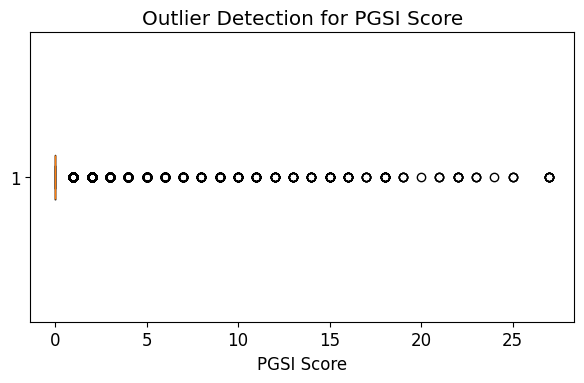

In [ ]:

df = combined_data2.copy()

plt.figure(figsize=(6, 4))
plt.boxplot(df["pgsi_Score"].dropna(), vert=False)
plt.title("Outlier Detection for PGSI Score")
plt.xlabel("PGSI Score")
plt.tight_layout()
plt.show()


Descriptive statistics of key variables (combined dataset, pgsi score, pgsi category and gambling participation )

summary statistics of the dataset

          Serial_no   Survey_Year    pgsi_Score  Gambling_Participation
count  2.577400e+04  25774.000000  25774.000000            25774.000000
mean   1.295447e+07   2020.459067      0.192791                0.747730
std    1.156433e+07      2.142666      1.344351                0.434324
min    2.800001e+06   2018.000000      0.000000                0.000000
25%    2.807608e+06   2018.000000      0.000000                0.000000
50%    1.002542e+07   2021.000000      0.000000                1.000000
75%    3.100082e+07   2023.000000      0.000000                1.000000
max    3.100865e+07   2023.000000     27.000000                1.000000 



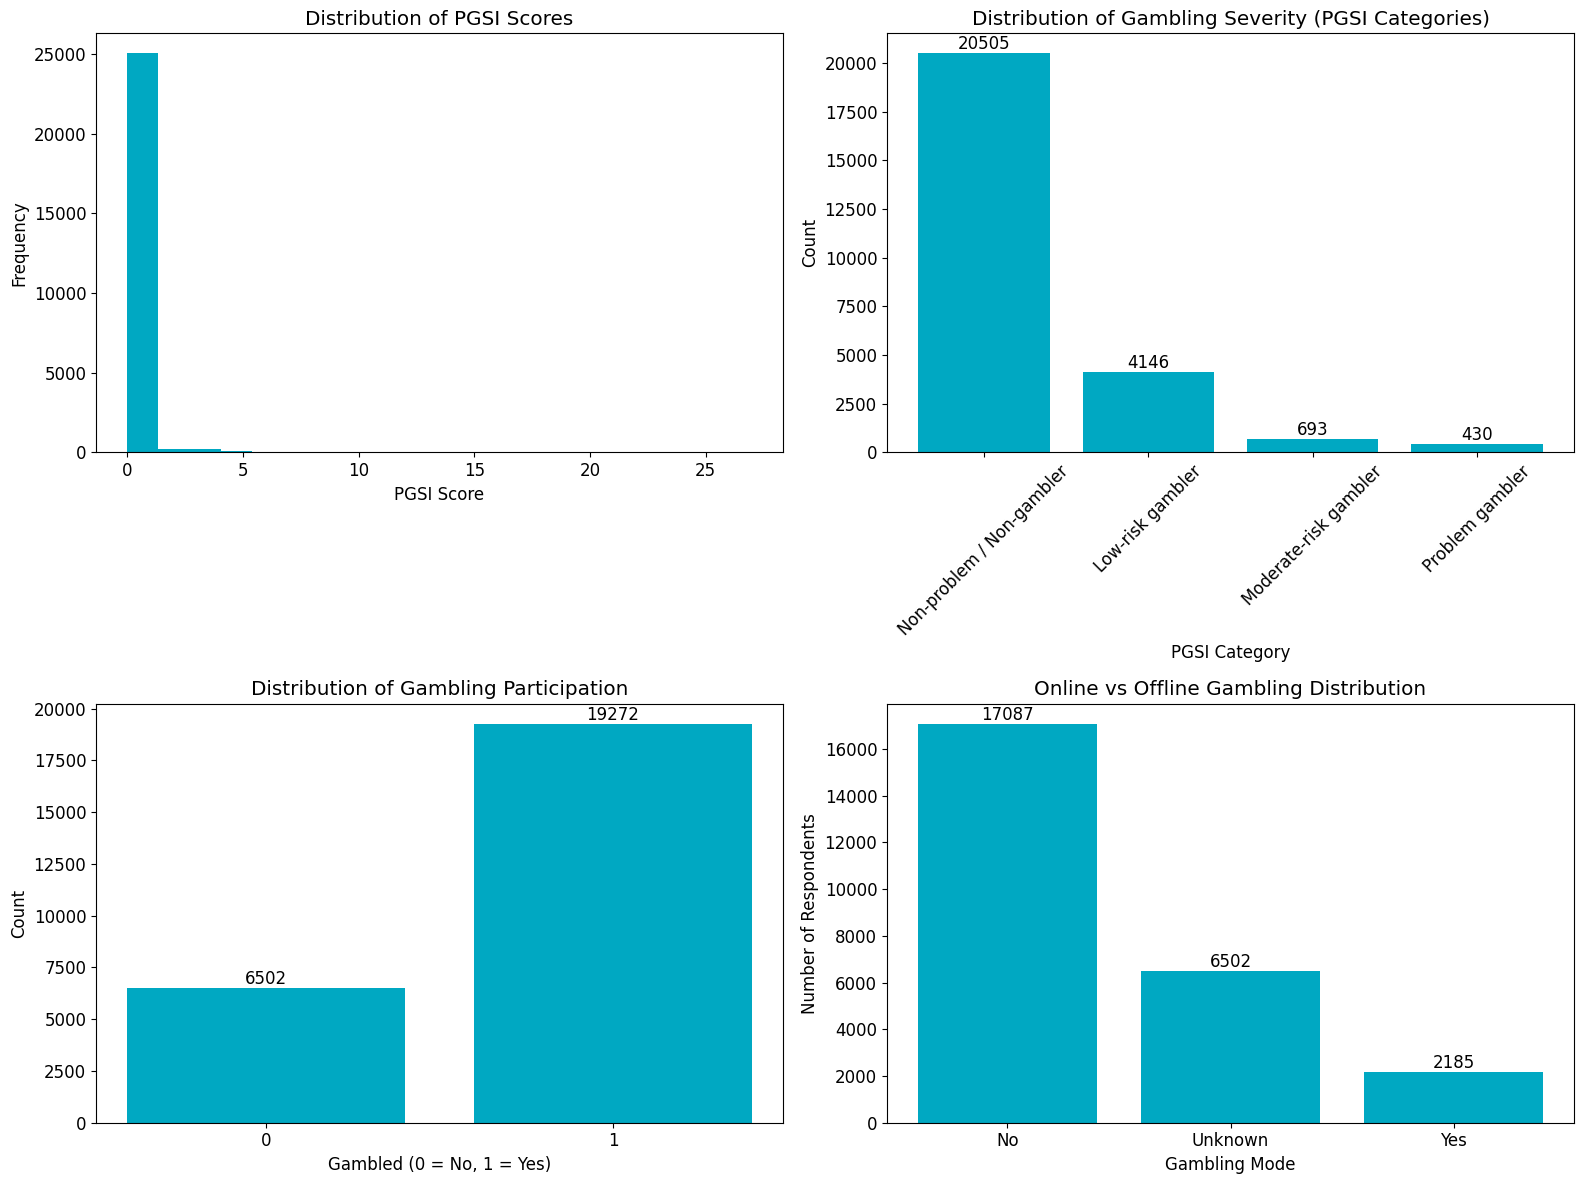

In [ ]:

# Load dataset
df = combined_data2.copy()
print("summary statistics of the dataset\n")
print(df.describe(), "\n") #summary statistics


# Create 2x2 canvas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Distribution of PGSI Scores
axes[0, 0].hist(df["pgsi_Score"].dropna(), bins=20,  color="#00A8C2")
axes[0, 0].set_title("Distribution of PGSI Scores")
axes[0, 0].set_xlabel("PGSI Score")
axes[0, 0].set_ylabel("Frequency")

#Distribution of Gambling Severity (PGSI Categories)
pgsi_dist = df["pgsi_category"].value_counts(dropna=False)
bars = axes[0, 1].bar(pgsi_dist.index.astype(str), pgsi_dist.values,  color="#00A8C2")
axes[0, 1].set_title("Distribution of Gambling Severity (PGSI Categories)")
axes[0, 1].set_xlabel("PGSI Category")
axes[0, 1].set_ylabel("Count")
axes[0, 1].tick_params(axis="x", rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

# Dstribution of Gambling Participation
gambled_counts = df["Gambling_Participation"].value_counts().sort_index()
bars = axes[1, 0].bar(gambled_counts.index.astype(str), gambled_counts.values,  color="#00A8C2")
axes[1, 0].set_title("Distribution of Gambling Participation")
axes[1, 0].set_xlabel("Gambled (0 = No, 1 = Yes)")
axes[1, 0].set_ylabel("Count")

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

#Online vs Offline Gambling Distribution
online_counts = df["Online_Gambling"].value_counts(dropna=False)
bars = axes[1, 1].bar(online_counts.index.astype(str), online_counts.values,  color="#00A8C2")
axes[1, 1].set_title("Online vs Offline Gambling Distribution")
axes[1, 1].set_xlabel("Gambling Mode")
axes[1, 1].set_ylabel("Number of Respondents")

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
    )

# Final layout
plt.tight_layout()
plt.show()


Gambling participation across survey years

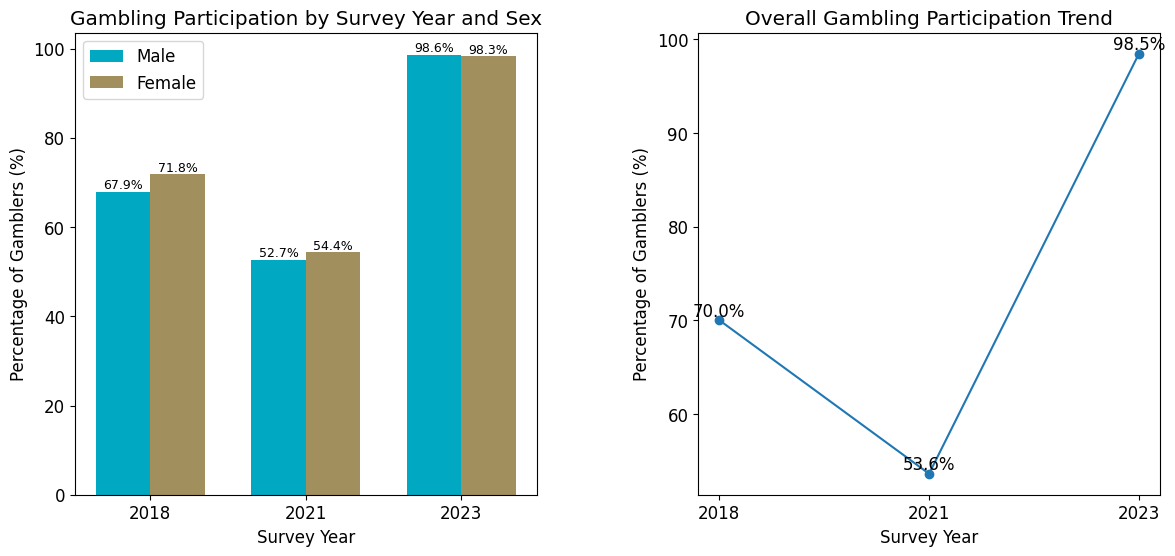

In [ ]:

# Load dataset
df = combined_data2.copy()

# Calculate participation by year & sex
sex_participation = (
    df.groupby(["Survey_Year", "Sex"])["Gambling_Participation"]
      .mean()
      .unstack() * 100
)

# Overall participation (for line plot)
overall_participation = (
    df.groupby("Survey_Year")["Gambling_Participation"]
      .mean() * 100
)

years = sex_participation.index.astype(str)

# Create 1x2 canvas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.35)

# LEFT: Grouped Bar Plot (Male vs Female)
bar_width = 0.35
x = np.arange(len(years))

male_vals = sex_participation["Male"]
female_vals = sex_participation["Female"]

color="#00A8C2"
bars_male = axes[0].bar(x - bar_width/2, male_vals, width=bar_width, label="Male", color="#00A8C2")
bars_female = axes[0].bar(x + bar_width/2, female_vals, width=bar_width, label="Female", color="#A18F5E")

axes[0].set_title("Gambling Participation by Survey Year and Sex")
axes[0].set_xlabel("Survey Year")
axes[0].set_ylabel("Percentage of Gamblers (%)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(years)
axes[0].legend()

# Add value labels
for bars in [bars_male, bars_female]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

# RIGHT: Line Plot (Overall Trend)
axes[1].plot(years, overall_participation.values, marker="o")
axes[1].set_title("Overall Gambling Participation Trend")
axes[1].set_xlabel("Survey Year")
axes[1].set_ylabel("Percentage of Gamblers (%)")

# Add value labels
for x_val, y_val in zip(years, overall_participation.values):
    axes[1].text(x_val, y_val, f"{y_val:.1f}%", ha="center", va="bottom")

plt.show()


Distribution of Gamblers across demographics varibles

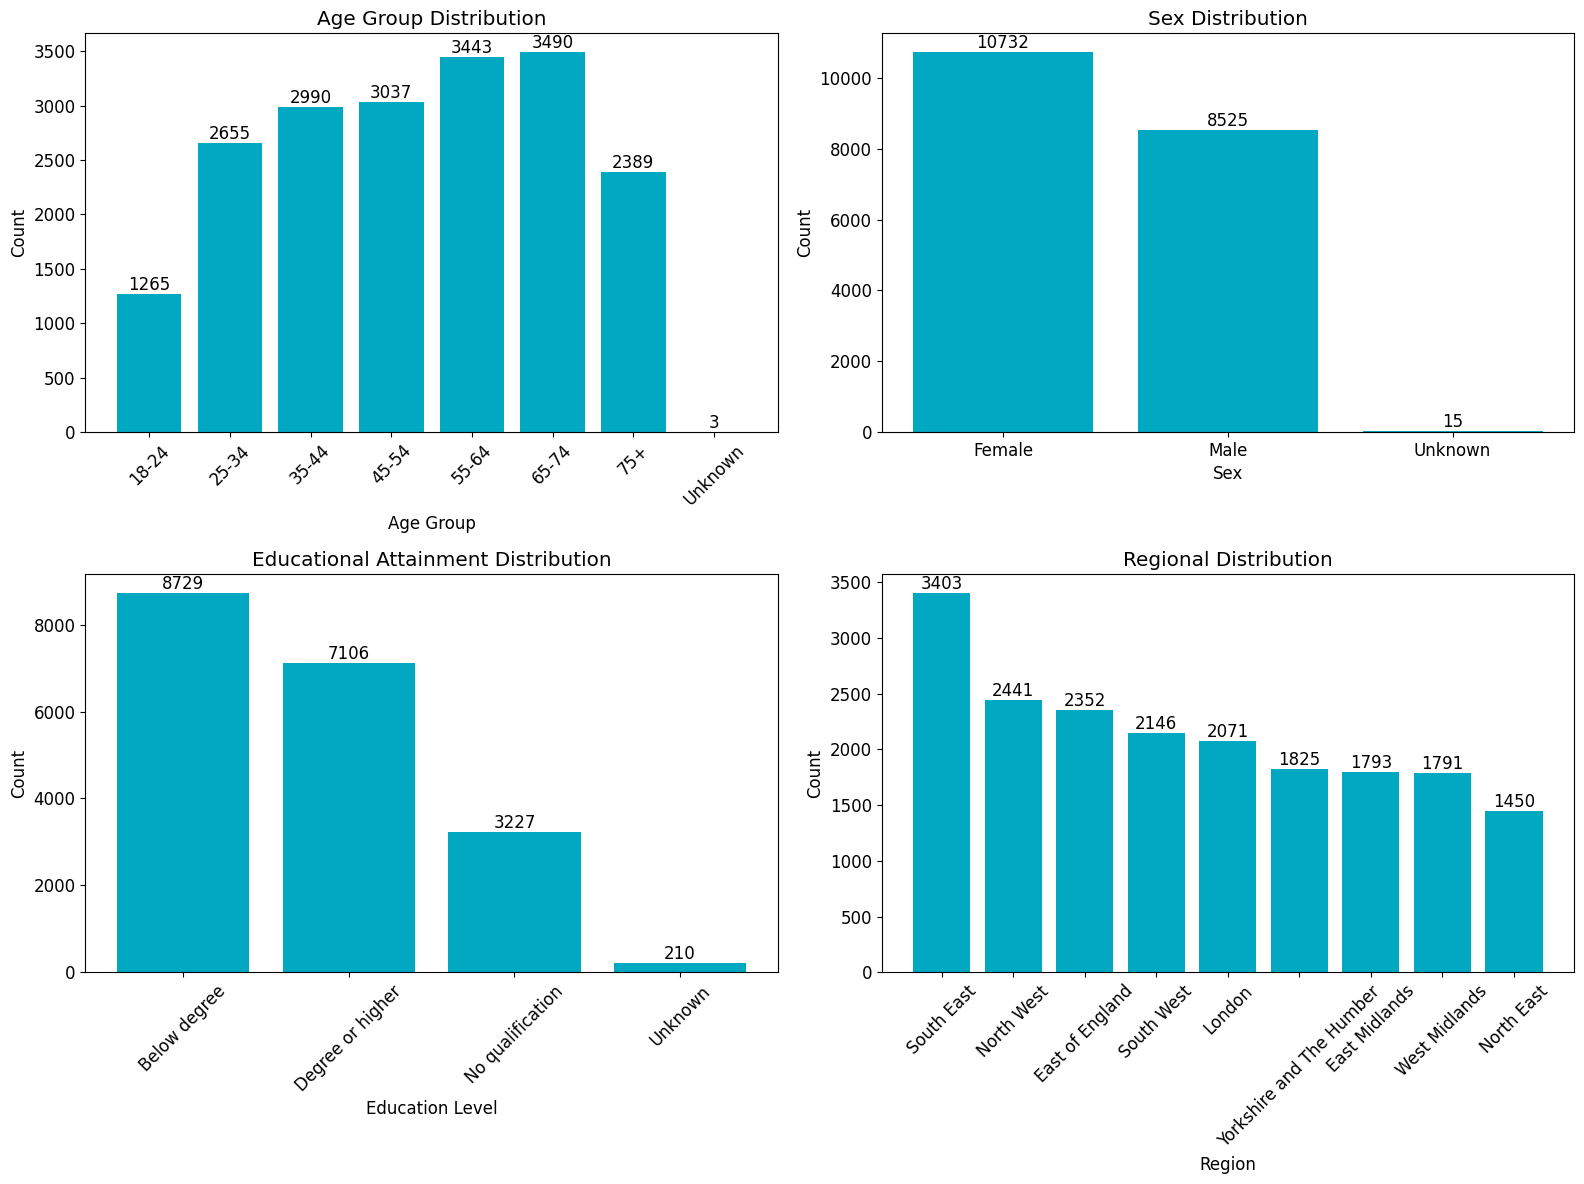

In [ ]:
df = df[combined_data2.copy()["Gambling_Participation"] == 1]
# Create 2x2 canvas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age Group Distribution
age_counts = df["Age_Group"].value_counts(dropna=False).sort_index()
bars = axes[0, 0].bar(age_counts.index.astype(str), age_counts.values, color="#00A8C2")
axes[0, 0].set_title("Age Group Distribution")
axes[0, 0].set_xlabel("Age Group")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=45)

for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

#Sex Distribution
sex_counts = df["Sex"].value_counts(dropna=False)
bars = axes[0, 1].bar(sex_counts.index.astype(str), sex_counts.values, color="#00A8C2")
axes[0, 1].set_title("Sex Distribution")
axes[0, 1].set_xlabel("Sex")
axes[0, 1].set_ylabel("Count")

for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

#Educational Attainment Distribution
edu_counts = df["Education_Level"].value_counts(dropna=False)
bars = axes[1, 0].bar(edu_counts.index.astype(str), edu_counts.values, color="#00A8C2")
axes[1, 0].set_title("Educational Attainment Distribution")
axes[1, 0].set_xlabel("Education Level")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis="x", rotation=45)

for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )
# Regional Distribution
region_counts = df["Region"].value_counts(dropna=False)
bars = axes[1, 1].bar(region_counts.index.astype(str), region_counts.values, color="#00A8C2")
axes[1, 1].set_title("Regional Distribution")
axes[1, 1].set_xlabel("Region")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis="x", rotation=45)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

# Final layout
plt.tight_layout()
plt.show()


Distribution of Gambling Participation Patterns 

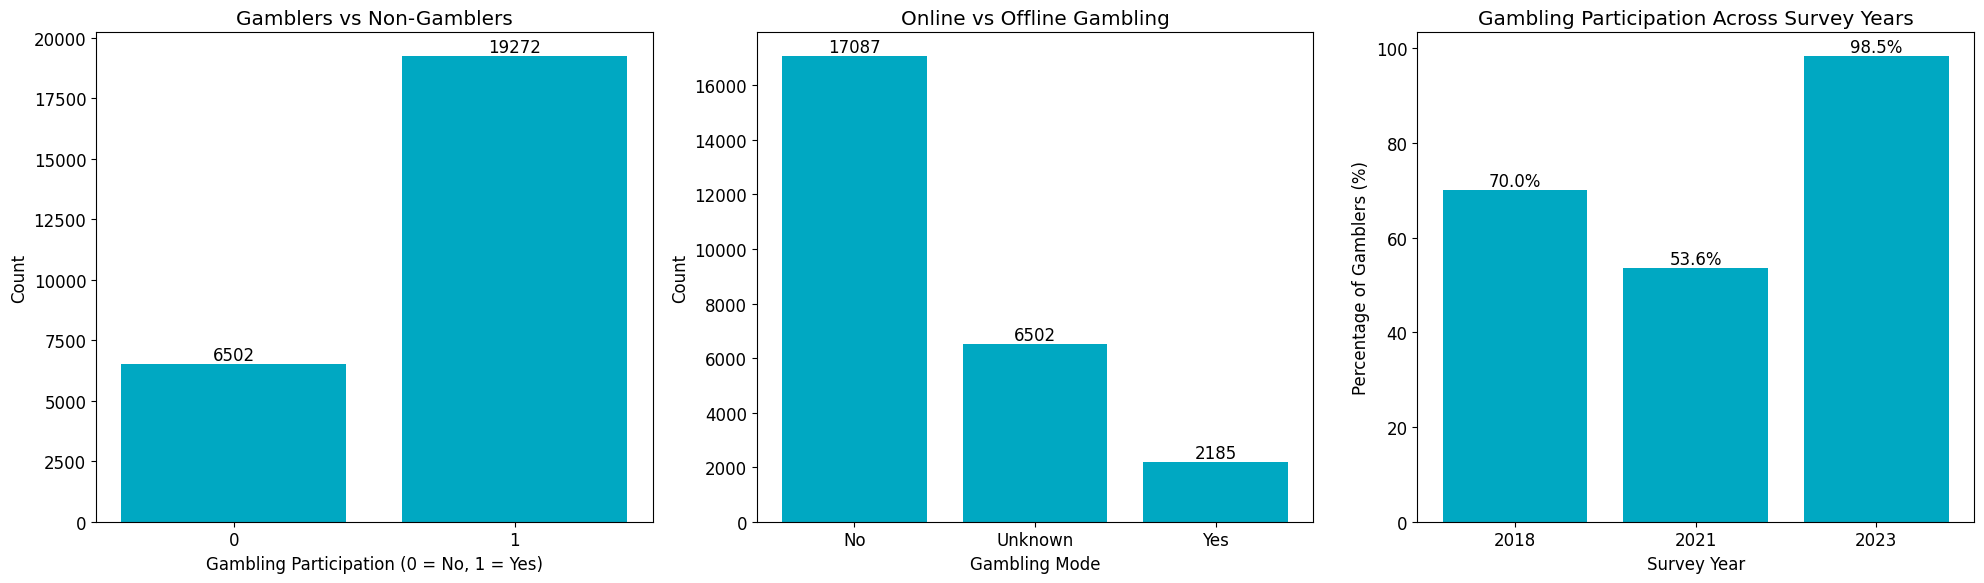

In [ ]:

# Load dataset
df = combined_data2.copy()

# Create 1x3 canvas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

#Proportion of Gamblers vs Non-Gamblers
gambled_counts = df["Gambling_Participation"].value_counts().sort_index()
bars = axes[0].bar(gambled_counts.index.astype(str), gambled_counts.values, color="#00A8C2")
axes[0].set_title("Gamblers vs Non-Gamblers")
axes[0].set_xlabel("Gambling Participation (0 = No, 1 = Yes)")
axes[0].set_ylabel("Count")

for bar in bars:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

#Online vs Offline Gambling Participation
online_counts = df["Online_Gambling"].value_counts(dropna=False)
bars = axes[1].bar(online_counts.index.astype(str), online_counts.values, color="#00A8C2")
axes[1].set_title("Online vs Offline Gambling")
axes[1].set_xlabel("Gambling Mode")
axes[1].set_ylabel("Count")

for bar in bars:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

#Gambling Participation Across Survey Years
year_participation = (
    df.groupby("Survey_Year")["Gambling_Participation"]
      .mean() * 100
)

bars = axes[2].bar(
    year_participation.index.astype(str),
    year_participation.values,
    color="#00A8C2"
)
axes[2].set_title("Gambling Participation Across Survey Years")
axes[2].set_xlabel("Survey Year")
axes[2].set_ylabel("Percentage of Gamblers (%)")

for bar in bars:
    height = bar.get_height()
    axes[2].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom"
    )

# Final layout
plt.tight_layout()
plt.show()


correlation analysis

correlation analysis (pgsi score, pgsi grouped and gambling participation)

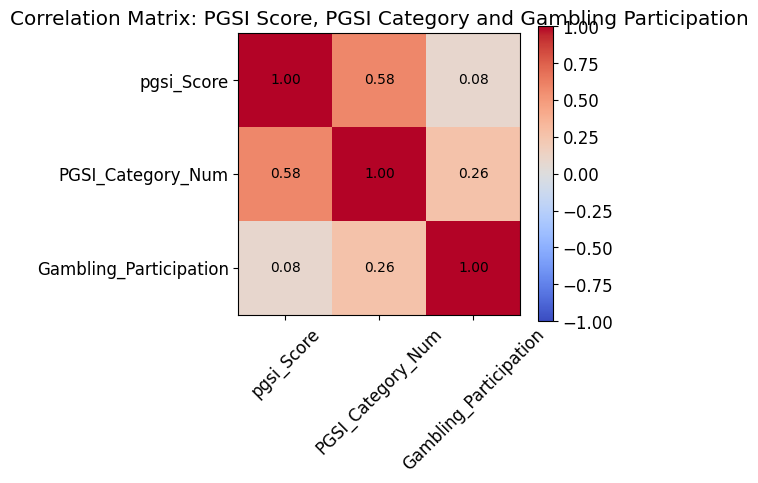

,pgsi_Score,PGSI_Category_Num,Gambling_Participation
pgsi_Score,1.00000,0.584310,0.083300
PGSI_Category_Num,0.58431,1.000000,0.260427
Gambling_Participation,0.08330,0.260427,1.000000


In [ ]:

df = combined_data2.copy()

# Map PGSI category to ordered numeric scale
pgsi_map = {
    "Non-problem / Non-gambler": 0,
    "Low-risk gambler": 1,
    "Moderate-risk gambler": 2,
    "Problem gambler": 3
}

df["PGSI_Category_Num"] = df["pgsi_category"].map(pgsi_map)

# Select variables
corr_df = df[
    ["pgsi_Score", "PGSI_Category_Num", "Gambling_Participation"]
].apply(pd.to_numeric, errors="coerce")

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap with desired colour scheme
plt.figure(figsize=(6, 5))
im = plt.imshow(
    corr_matrix,
    cmap="coolwarm", 
    vmin=-1,
    vmax=1,
    aspect="equal"
)
plt.colorbar(im)

plt.xticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns,
    rotation=45
)
plt.yticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns
)

# Add numeric values inside each cell
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        plt.text(
            j, i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color="black",
            fontsize=10
        )

plt.title(
    "Correlation Matrix: PGSI Score, PGSI Category and Gambling Participation"
)
plt.tight_layout()
plt.show()

corr_matrix


correlation of categorical variables and PGSI Score

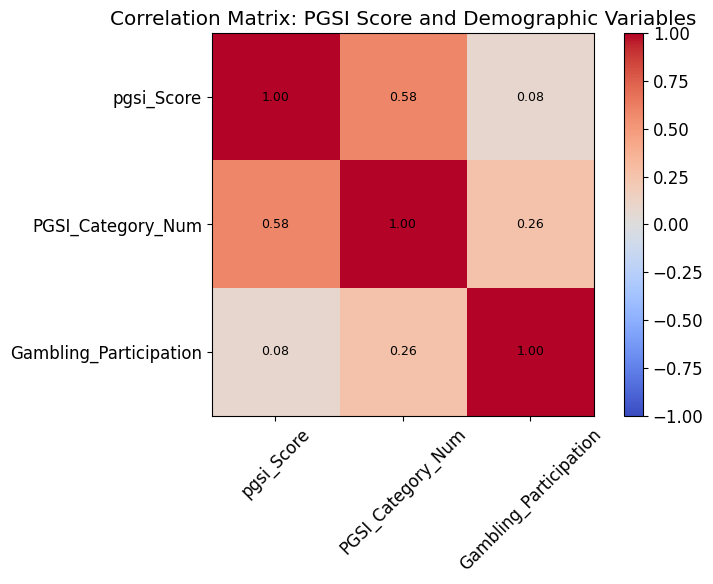

In [ ]:
df = combined_data2.copy()

plt.figure(figsize=(8, 6))
im = plt.imshow(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    aspect="equal"
)
plt.colorbar(im)

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Annotate values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        plt.text(
            j, i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color="black",
            fontsize=9
        )

plt.title("Correlation Matrix: PGSI Score and Demographic Variables")
plt.tight_layout()
plt.show()


WHAT IS THE TREND IN GAMBLING PARTICIPATION AND GAMBLING SEVERITY AMONG UK ADULTS ACROSS SURVEY YEARS?

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


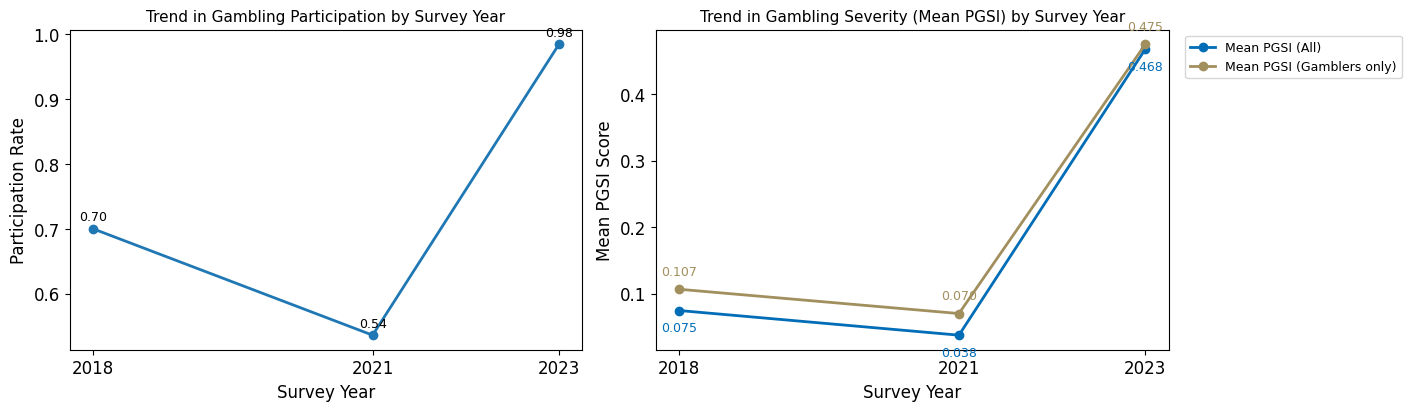

In [ ]:
# Copy dataset
df = combined_data2.copy()

# Ensure correct types
df["pgsi_Score"] = pd.to_numeric(df["pgsi_Score"], errors="coerce")
df["Gambling_Participation"] = pd.to_numeric(df["Gambling_Participation"], errors="coerce")
df["Survey_Year"] = pd.to_numeric(df["Survey_Year"], errors="coerce")

# Drop invalid rows
df = df.dropna(subset=["Survey_Year", "Gambling_Participation"])
df["Gambling_Participation"] = df["Gambling_Participation"].astype(int)

# Create trend table
trend = (
    df.groupby("Survey_Year")
      .apply(lambda g: pd.Series({
          "participation_rate": (g["Gambling_Participation"] == 1).mean(),
          "mean_pgsi_all": g["pgsi_Score"].mean(skipna=True),
          "mean_pgsi_gamblers": g.loc[
              g["Gambling_Participation"] == 1, "pgsi_Score"
          ].mean(skipna=True)
      }))
      .reset_index()
      .sort_values("Survey_Year")
)

# Create 1×2 canvas
fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# Add space between plots
plt.subplots_adjust(wspace=0.35)

# LEFT: Participation trend
axes[0].plot(
    trend["Survey_Year"],
    trend["participation_rate"],
    marker="o",
    linewidth=2
)

for x, y in zip(trend["Survey_Year"], trend["participation_rate"]):
    axes[0].annotate(
        f"{y:.2f}",
        (x, y),
        textcoords="offset points",
        xytext=(0, 6),
        ha="center",
        fontsize=9
    )

axes[0].set_title("Trend in Gambling Participation by Survey Year", fontsize=11)
axes[0].set_xlabel("Survey Year")
axes[0].set_ylabel("Participation Rate")
axes[0].set_xticks(trend["Survey_Year"])

# RIGHT: Severity trend

axes[1].plot(
    trend["Survey_Year"],
    trend["mean_pgsi_all"],
    marker="o",
    linewidth=2,
    label="Mean PGSI (All)",
    color="#006DB6"
)

axes[1].plot(
    trend["Survey_Year"],
    trend["mean_pgsi_gamblers"],
    marker="o",
    linewidth=2,
    label="Mean PGSI (Gamblers only)",
    color="#A18F5E"
)

# Add value labels ABOVE the lines (no overlap)

# Mean PGSI (All)
for x, y in zip(trend["Survey_Year"], trend["mean_pgsi_all"]):
    axes[1].annotate(
        f"{y:.3f}",
        (x, y),
        textcoords="offset points",
        xytext=(0, -15),
        ha="center",
        fontsize=9,
        color="#006DB6"
    )

# Mean PGSI (Gamblers only)
for x, y in zip(trend["Survey_Year"], trend["mean_pgsi_gamblers"]):
    axes[1].annotate(
        f"{y:.3f}",
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=9,
        color="#A18F5E"
    )


axes[1].set_title("Trend in Gambling Severity (Mean PGSI) by Survey Year", fontsize=11)
axes[1].set_xlabel("Survey Year")
axes[1].set_ylabel("Mean PGSI Score")
axes[1].set_xticks(trend["Survey_Year"])

# Legend outside (right)
axes[1].legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    fontsize=9
)

plt.show()


WHICH GENDER EXPEREINCE MORE GAMBLING HARM?

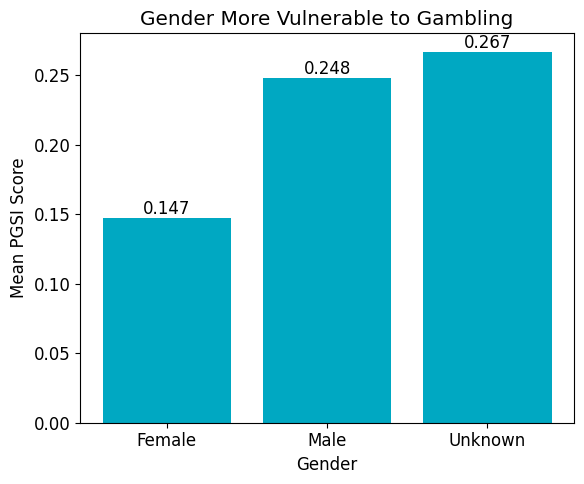

Sex
Female     0.147240
Male       0.248192
Unknown    0.266667
Name: pgsi_Score, dtype: float64

In [ ]:

# Load dataset
df = combined_data2.copy()

# Ensure PGSI score is numeric
df["pgsi_Score"] = pd.to_numeric(df["pgsi_Score"], errors="coerce")

# Calculate mean PGSI score by gender
gender_pgsi = df.groupby("Sex")["pgsi_Score"].mean()

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(gender_pgsi.index.astype(str), gender_pgsi.values, color = "#00A8C2")
plt.title("Gender More Vulnerable to Gambling")
plt.xlabel("Gender")
plt.ylabel("Mean PGSI Score")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

gender_pgsi


WHAT IS THE IMPACT OF GAMBLING SEVERITY ACROSS UK REGIONS?

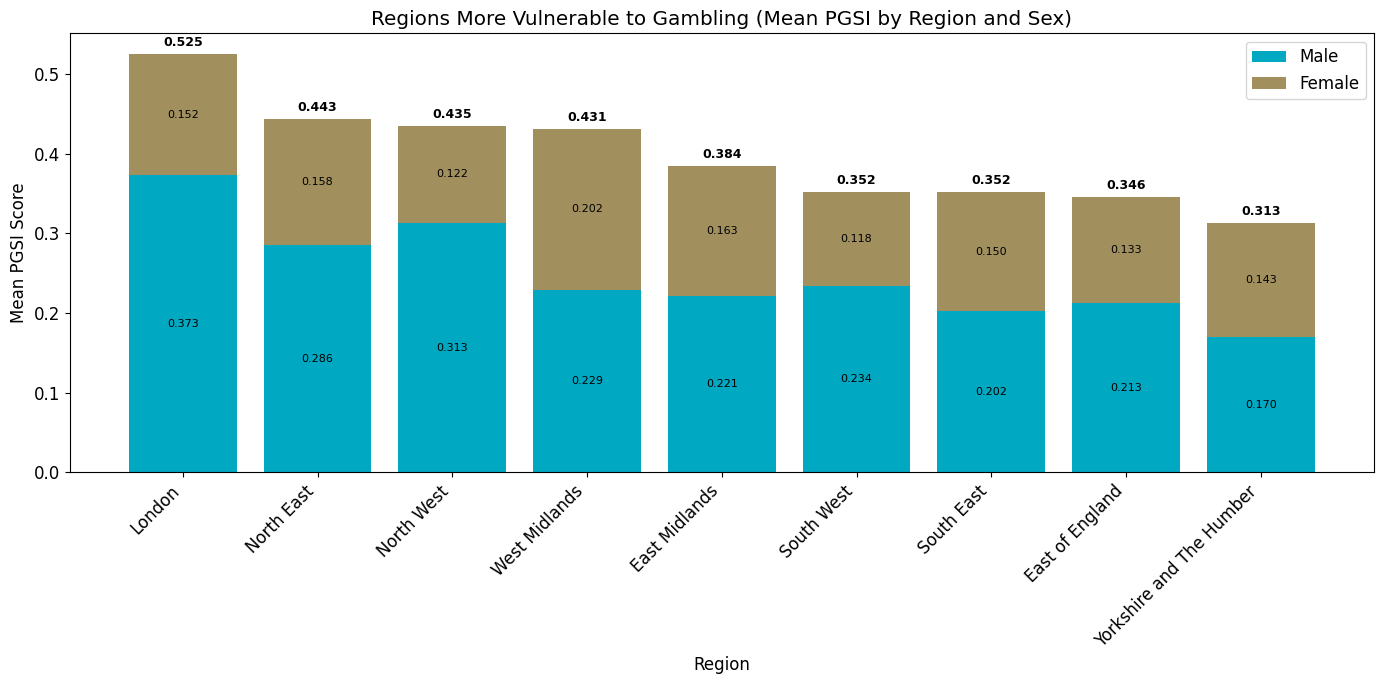

In [ ]:
# Load data
df = combined_data2.copy()

# Ensure numeric PGSI
df["pgsi_Score"] = pd.to_numeric(df["pgsi_Score"], errors="coerce")

# Keep only male and female
df = df[df["Sex"].isin(["Male", "Female"])]

# Compute mean PGSI by region × sex
mean_pgsi = df.groupby(["Region", "Sex"])["pgsi_Score"].mean().unstack(fill_value=0)

# Compute total mean PGSI
mean_pgsi["Total"] = mean_pgsi["Male"] + mean_pgsi["Female"]

# Sort by total mean severity
mean_pgsi = mean_pgsi.sort_values("Total", ascending=False)

# Plot stacked mean PGSI
plt.figure(figsize=(14,7))

male_vals = mean_pgsi["Male"]
female_vals = mean_pgsi["Female"]
regions = mean_pgsi.index

plt.bar(regions, male_vals, label="Male", color="#00A8C2")
plt.bar(regions, female_vals, bottom=male_vals, label="Female", color="#A18F5E")



# Add labels inside male bars
for i, v in enumerate(male_vals):
    if v > 0:
        plt.text(i, v/2, f"{v:.3f}", ha="center", va="center", color="#000000", fontsize=8)

# Add labels inside female bars
for i, (m, f) in enumerate(zip(male_vals, female_vals)):
    if f > 0:
        plt.text(i, m + f/2, f"{f:.3f}", ha="center", va="center", color="#000000", fontsize=8)

# Add total mean on top
for i, total in enumerate(mean_pgsi["Total"]):
    plt.text(i, total + 0.01, f"{total:.3f}", ha="center", fontsize=9, fontweight="bold")

plt.title("Regions More Vulnerable to Gambling (Mean PGSI by Region and Sex)")
plt.ylabel("Mean PGSI Score")
plt.xlabel("Region")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


WHICH AGE GROUP ARE MORE VULNERABLE TO GAMBLING?

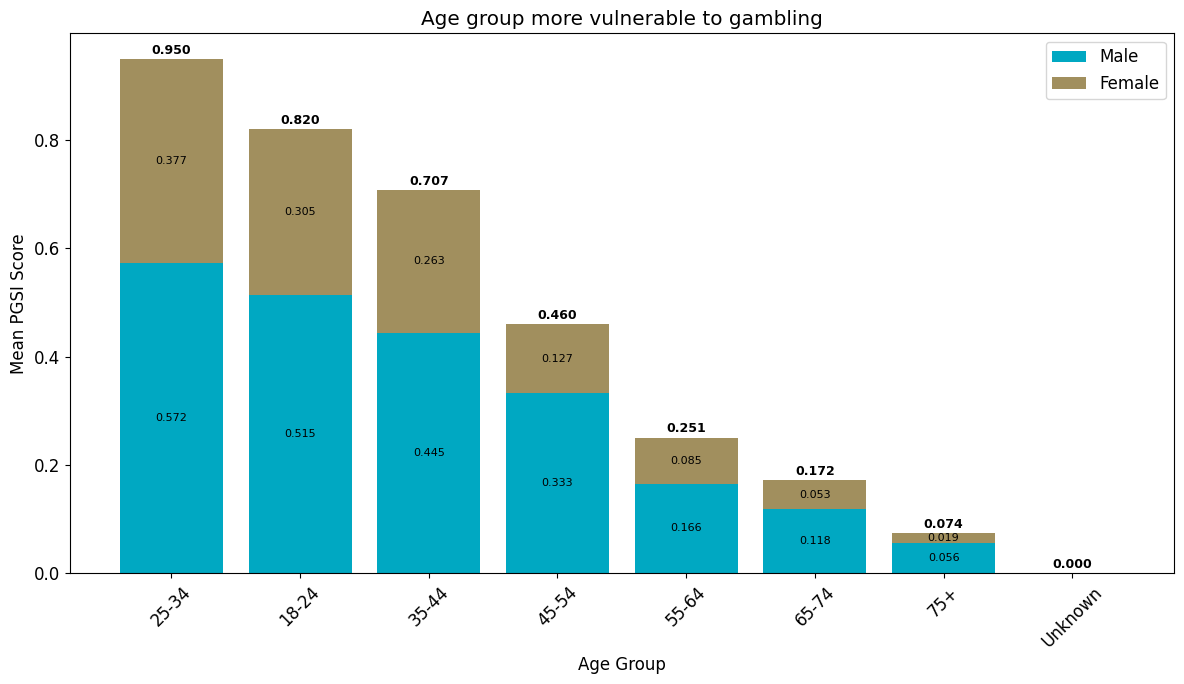

In [ ]:
df = combined_data2.copy()

# Ensure PGSI numeric
df["pgsi_Score"] = pd.to_numeric(df["pgsi_Score"], errors="coerce")

# Keep only male and female
df = df[df["Sex"].isin(["Male", "Female"])]

# Compute mean PGSI by age × sex
age_sex_pgsi = df.groupby(["Age_Group", "Sex"])["pgsi_Score"].mean().unstack(fill_value=0)

# Compute total mean PGSI for sorting & labels
age_sex_pgsi["Total"] = age_sex_pgsi["Male"] + age_sex_pgsi["Female"]

# Sort age groups by total severity
age_sex_pgsi = age_sex_pgsi.sort_values("Total", ascending=False)

# Extract values
ages = age_sex_pgsi.index
male_vals = age_sex_pgsi["Male"]
female_vals = age_sex_pgsi["Female"]

# Plot stacked bar chart
plt.figure(figsize=(12,7))

# Male = bottom
plt.bar(ages, male_vals, label="Male", color="#00A8C2")

# Female = stacked on top
plt.bar(ages, female_vals, bottom=male_vals, label="Female", color="#A18F5E")

# Add labels inside male bars
for i, v in enumerate(male_vals):
    if v > 0:
        plt.text(i, v/2, f"{v:.3f}", ha="center", va="center", color="#000000", fontsize=8)

# Add labels inside female bars
for i, (m, f) in enumerate(zip(male_vals, female_vals)):
    if f > 0:
        plt.text(i, m + f/2, f"{f:.3f}", ha="center", va="center", color="#000000", fontsize=8)

# Add total label on top of bars
for i, t in enumerate(age_sex_pgsi["Total"]):
    plt.text(i, t + 0.01, f"{t:.3f}", ha="center", fontsize=9, fontweight="bold")

plt.title("Age group more vulnerable to gambling")
plt.xlabel("Age Group")
plt.ylabel("Mean PGSI Score")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# age_sex_pgsi

WHICH EDUCATIONAL GROUP IS MORE VULNERABLE TO GAMBLING  

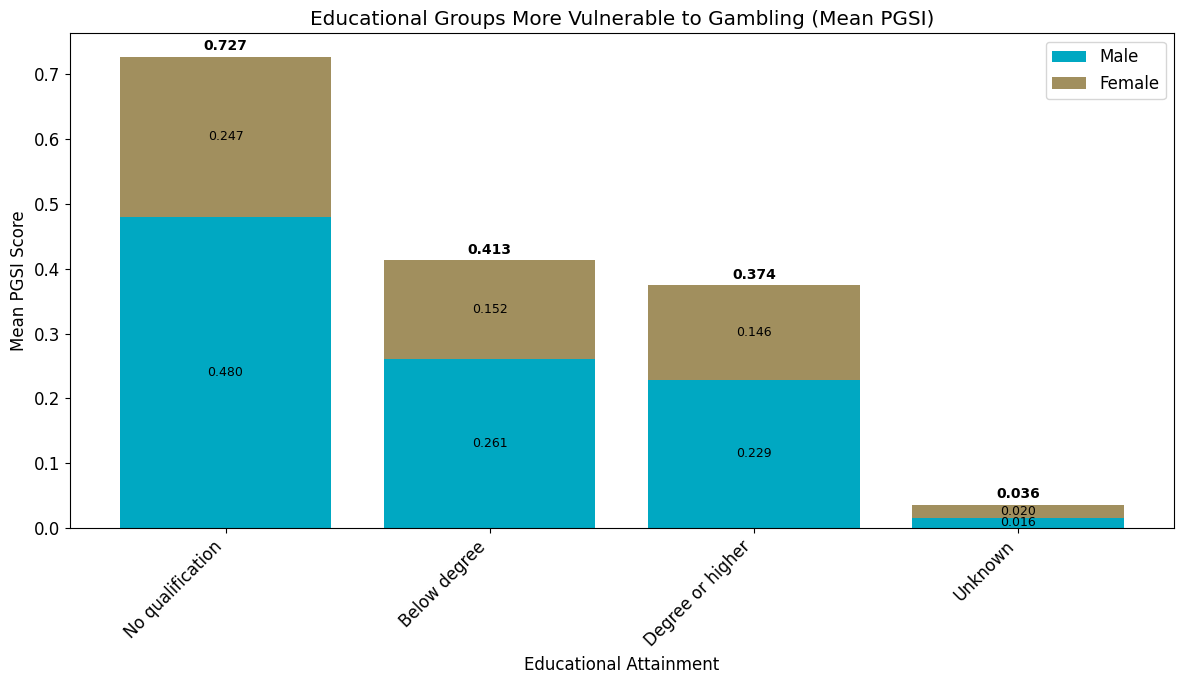

In [ ]:
# Load data
df = combined_data2.copy()

# Ensure PGSI numeric
df["pgsi_Score"] = pd.to_numeric(df["pgsi_Score"], errors="coerce")

# Keep only male and female
df = df[df["Sex"].isin(["Male", "Female"])]

# Compute mean PGSI by education × sex
edu_sex_pgsi = (
    df.groupby(["Education_Level", "Sex"])["pgsi_Score"]
      .mean()
      .unstack(fill_value=0)
)

# Compute total mean PGSI
edu_sex_pgsi["Total"] = edu_sex_pgsi["Male"] + edu_sex_pgsi["Female"]

# Sort by total severity
edu_sex_pgsi = edu_sex_pgsi.sort_values("Total", ascending=False)

# Extract values
edu_levels = edu_sex_pgsi.index
male_vals = edu_sex_pgsi["Male"]
female_vals = edu_sex_pgsi["Female"]

# Plot stacked bar chart
plt.figure(figsize=(12,7))
plt.bar(edu_levels, male_vals, label="Male", color="#00A8C2")
plt.bar(edu_levels, female_vals, bottom=male_vals, label="Female", color="#A18F5E")

# Add value labels inside stacks
for i, v in enumerate(male_vals):
    if v > 0:
        plt.text(i, v/2, f"{v:.3f}", ha="center", va="center", color="#000000", fontsize=9)

for i, (m, f) in enumerate(zip(male_vals, female_vals)):
    if f > 0:
        plt.text(i, m + f/2, f"{f:.3f}", ha="center", va="center", color="#000000", fontsize=9)
# Add total labels on top
for i, t in enumerate(edu_sex_pgsi["Total"]):
    plt.text(i, t + 0.01, f"{t:.3f}", ha="center", fontsize=10, fontweight="bold")

plt.title("Educational Groups More Vulnerable to Gambling (Mean PGSI)")
plt.xlabel("Educational Attainment")
plt.ylabel("Mean PGSI Score")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# edu_sex_pgsi


PROBABILITY THAT AN INDIVIDUAL WILL BECOME A SEVERE GAMBLER

Model development and evaluation

In [ ]:
# Target variable

df = combined_data2.copy()
df["pgsi_Score"] = pd.to_numeric(df["pgsi_Score"], errors="coerce")
df["severe_gambler"] = (df["pgsi_Score"] >= 8).astype(int)

# predictors
predictors = [
    "Sex",
    "Age_Group",
    "Education_Level",
    "Region",
    "Online_Gambling",
    "Gambling_Participation",
]

df = df[predictors + ["severe_gambler"]].dropna()



In [ ]:
# one-hot encoding
df_encoded = pd.get_dummies(df, columns=[
    "Sex","Age_Group","Education_Level",
    "Region","Online_Gambling", "Gambling_Participation"
], drop_first=True)

X = df_encoded.drop("severe_gambler", axis=1)
y = df_encoded["severe_gambler"]

In [ ]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic regression

In [ ]:
results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

#model evaluation
results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr, zero_division=0),
    "F1": f1_score(y_test, y_pred_lr, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_lr)
}

results["Logistic Regression"]

{'Accuracy': 0.9928225024248303,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1': 0.0,
 'ROC-AUC': 0.8876276628328211,
 'Confusion Matrix': array([[5118,    0],
        [  37,    0]], dtype=int64)}

Random forest

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#model evaluation
results["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, zero_division=0),
    "Recall": recall_score(y_test, y_pred_rf, zero_division=0),
    "F1": f1_score(y_test, y_pred_rf, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_rf)
}
results["Random Forest"]

{'Accuracy': 0.9926285160038797,
 'Precision': 0.42857142857142855,
 'Recall': 0.08108108108108109,
 'F1': 0.13636363636363635,
 'ROC-AUC': 0.6900182714954111,
 'Confusion Matrix': array([[5114,    4],
        [  34,    3]], dtype=int64)}

Support Vector Machine

In [ ]:

# Support vector machine (SVM)
svm = SVC(probability=True, kernel="rbf")
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

#model evaluation
results["SVM"] = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm, zero_division=0),
    "Recall": recall_score(y_test, y_pred_svm, zero_division=0),
    "F1": f1_score(y_test, y_pred_svm, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:,1]),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_svm)
}

results["SVM"]

{'Accuracy': 0.9928225024248303,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1': 0.0,
 'ROC-AUC': 0.6950323711753958,
 'Confusion Matrix': array([[5118,    0],
        [  37,    0]], dtype=int64)}

Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

#model evaluation
results["gb"] = {
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision": precision_score(y_test, y_pred_gb, zero_division=0),
    "Recall": recall_score(y_test, y_pred_gb, zero_division=0),
    "F1": f1_score(y_test, y_pred_gb, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, gb.predict_proba(X_test_scaled)[:,1]),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_gb)
}

results["gb"]

{'Accuracy': 0.9924345295829292,
 'Precision': 0.375,
 'Recall': 0.08108108108108109,
 'F1': 0.13333333333333333,
 'ROC-AUC': 0.8673098655513661,
 'Confusion Matrix': array([[5113,    5],
        [  34,    3]], dtype=int64)}

Model Evaluation

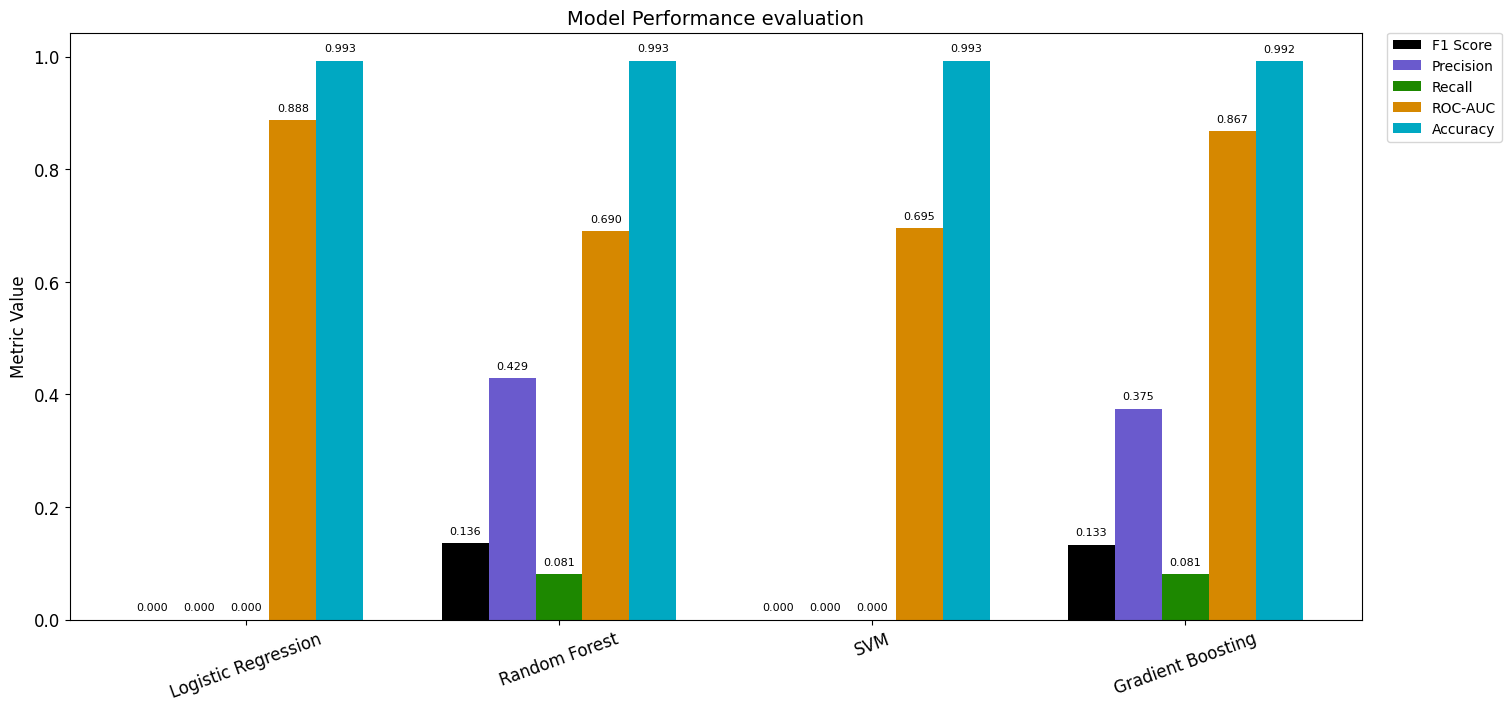

In [ ]:
# Model names
models = ["Logistic Regression", "Random Forest", "SVM", "Gradient Boosting"]

# F1 scores
f1_scores = [
    results["Logistic Regression"]["F1"],
    results["Random Forest"]["F1"],
    results["SVM"]["F1"],
    results["gb"]["F1"]
]

# ROC-AUC scores
roc_auc_scores = [
    results["Logistic Regression"]["ROC-AUC"],
    results["Random Forest"]["ROC-AUC"],
    results["SVM"]["ROC-AUC"],
    results["gb"]["ROC-AUC"]
]

# Accuracy scores
accuracy_scores = [
    results["Logistic Regression"]["Accuracy"],
    results["Random Forest"]["Accuracy"],
    results["SVM"]["Accuracy"],
    results["gb"]["Accuracy"]
]

# Precision scores
precision_scores = [
    results["Logistic Regression"]["Precision"],
    results["Random Forest"]["Precision"],
    results["SVM"]["Precision"],
    results["gb"]["Precision"]
]

# Recall scores
recall_scores = [
    results["Logistic Regression"]["Recall"],
    results["Random Forest"]["Recall"],
    results["SVM"]["Recall"],
    results["gb"]["Recall"]
]

# Set up bar positions
x = np.arange(len(models))
width = 0.15  # adjust width for 5 metrics

fig, ax = plt.subplots(figsize=(15, 7), constrained_layout=True)

# Bars for each metric
bars_f1 = ax.bar(x - 2*width, f1_scores, width, label="F1 Score", color="#000000")
bars_precision = ax.bar(x - width, precision_scores, width, label="Precision", color="#6A5ACD")
bars_recall = ax.bar(x, recall_scores, width, label="Recall", color="#1D8800")
bars_roc = ax.bar(x + width, roc_auc_scores, width, label="ROC-AUC", color="#D68800")
bars_acc = ax.bar(x + 2*width, accuracy_scores, width, label="Accuracy", color="#00A8C2")

# Function to add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 5),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8
        )

# Add labels for all metric bars
add_labels(bars_f1)
add_labels(bars_precision)
add_labels(bars_recall)
add_labels(bars_roc)
add_labels(bars_acc)

# Axes & labels
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=20)
ax.set_ylabel("Metric Value", fontsize=12)
ax.set_title("Model Performance evaluation", fontsize=14)

# Legend outside plot
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    fontsize=10
)

plt.show()


In [ ]:
#model evaluation
results

{'Logistic Regression': {'Accuracy': 0.9928225024248303,
  'Precision': 0.0,
  'Recall': 0.0,
  'F1': 0.0,
  'ROC-AUC': 0.8876276628328211,
  'Confusion Matrix': array([[5118,    0],
         [  37,    0]], dtype=int64)},
 'Random Forest': {'Accuracy': 0.9926285160038797,
  'Precision': 0.42857142857142855,
  'Recall': 0.08108108108108109,
  'F1': 0.13636363636363635,
  'ROC-AUC': 0.6900182714954111,
  'Confusion Matrix': array([[5114,    4],
         [  34,    3]], dtype=int64)},
 'SVM': {'Accuracy': 0.9928225024248303,
  'Precision': 0.0,
  'Recall': 0.0,
  'F1': 0.0,
  'ROC-AUC': 0.6950323711753958,
  'Confusion Matrix': array([[5118,    0],
         [  37,    0]], dtype=int64)},
 'gb': {'Accuracy': 0.9924345295829292,
  'Precision': 0.375,
  'Recall': 0.08108108108108109,
  'F1': 0.13333333333333333,
  'ROC-AUC': 0.8673098655513661,
  'Confusion Matrix': array([[5113,    5],
         [  34,    3]], dtype=int64)}}

HYPERPARAMETER TUNING

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

gb = GradientBoostingClassifier()

param_dist = {
    'n_estimators': randint(80, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(2, 5),
    'subsample': uniform(0.7, 0.3),
    'min_samples_split': randint(2, 10)
}

random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=20,             # Only 20 model runs (FAST)
    scoring='roc_auc',
    cv=3,                  # 3-fold CV (FAST + acceptable)
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

best_gb = random_search.best_estimator_
print("BEST PARAMETERS:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
BEST PARAMETERS: {'learning_rate': 0.2030510614528276, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 108, 'subsample': 0.9406590942262119}


EVALUATE IMPROVED MODEL

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

y_pred_best = best_gb.predict(X_test_scaled)
y_prob_best = best_gb.predict_proba(X_test_scaled)[:,1]

print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned F1:", f1_score(y_test, y_pred_best, zero_division=0))
print("Tuned ROC-AUC:", roc_auc_score(y_test, y_prob_best))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Tuned Accuracy: 0.9924345295829292
Tuned F1: 0.09302325581395349
Tuned ROC-AUC: 0.8738421891997508


ORIGINAL MODEL VS IMPROVED MODEL

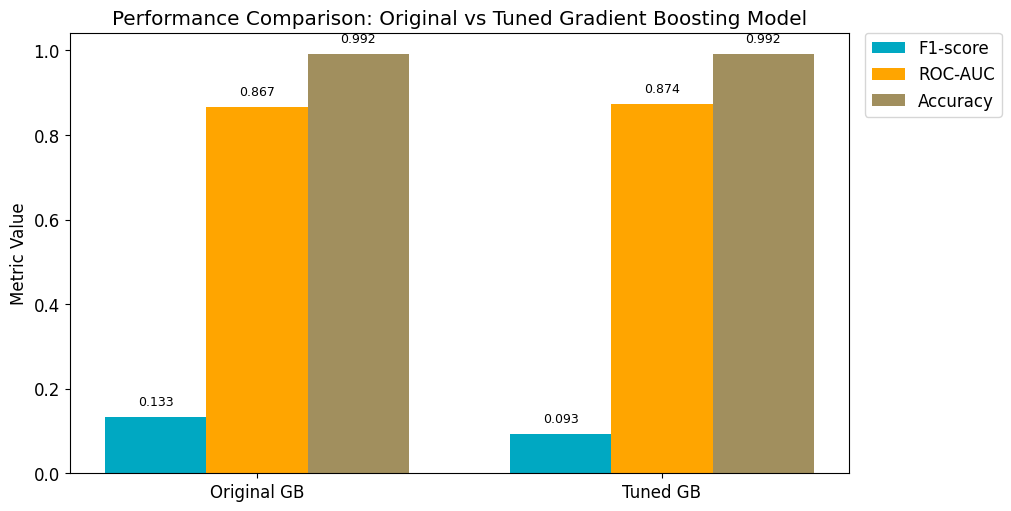

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Models on x-axis
models = ["Original GB", "Tuned GB"]

# Metrics (UNCHANGED values)
accuracy = [
    results["gb"]["Accuracy"],
    accuracy_score(y_test, y_pred_best)
]

f1 = [
    results["gb"]["F1"],
    f1_score(y_test, y_pred_best, zero_division=0)
]

roc_auc = [
    results["gb"]["ROC-AUC"],
    roc_auc_score(y_test, y_prob_best)
]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# 🔁 REORDERED BARS (F1 → ROC-AUC → Accuracy)
bars_f1 = ax.bar(x - width, f1, width, label="F1-score", color="#00A8C2")
bars_auc = ax.bar(x, roc_auc, width, label="ROC-AUC", color="#FFA500")
bars_acc = ax.bar(x + width, accuracy, width, label="Accuracy", color="#A18F5E")

# Value labels
for bars in [bars_f1, bars_auc, bars_acc]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9
        )

# Axes & title
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("Metric Value")
ax.set_title("Performance Comparison: Original vs Tuned Gradient Boosting Model")

# Legend (already correct placement)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

plt.show()


SAVE TUNED MODEL

In [ ]:
# Save the tuned model
import joblib
joblib.dump(best_gb, r"C:\Users\Admin\Documents\gambling project\models\best_model\best_model.pkl")

['C:\\Users\\Admin\\Documents\\gambling project\\models\\best_model\\best_model.pkl']

In [ ]:
# Predict probability of becoming severe gambler
import joblib


# Load the model
loaded_model = joblib.load(r"C:\Users\Admin\Documents\gambling project\models\best_model\best_model.pkl")

# Predict probabilities
probabilities = loaded_model.predict_proba(X_test_scaled)[:, 1]


# Return the first 20 probabilities
# probabilities[:10]

# given probabilities array
# probabilities = probabilities[:10]

# create dataframe
df_probabilities = pd.DataFrame({
    "Observation": range(1, len(probabilities) + 1),
    "Predicted Probability": probabilities
})

display(df_probabilities)
print("The probability that an individual will be a severe gambler is", (probabilities.mean()*100).round(2),"%" )

,Observation,Predicted Probability
0,1,0.000204
1,2,0.000176
2,3,0.008524
3,4,0.006187
4,5,0.000655
...,...,...
5150,5151,0.047485
5151,5152,0.000549
5152,5153,0.000372
5153,5154,0.000292


The probability that an individual will be a severe gambler is 0.72 %


ROC AUC curve

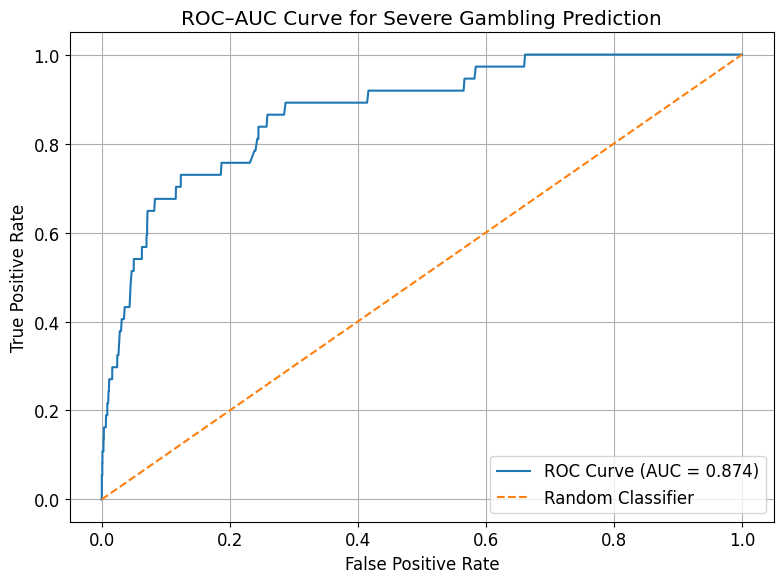

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the positive class
probabilities

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Compute AUC score
auc_score = roc_auc_score(y_test, probabilities)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve for Severe Gambling Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


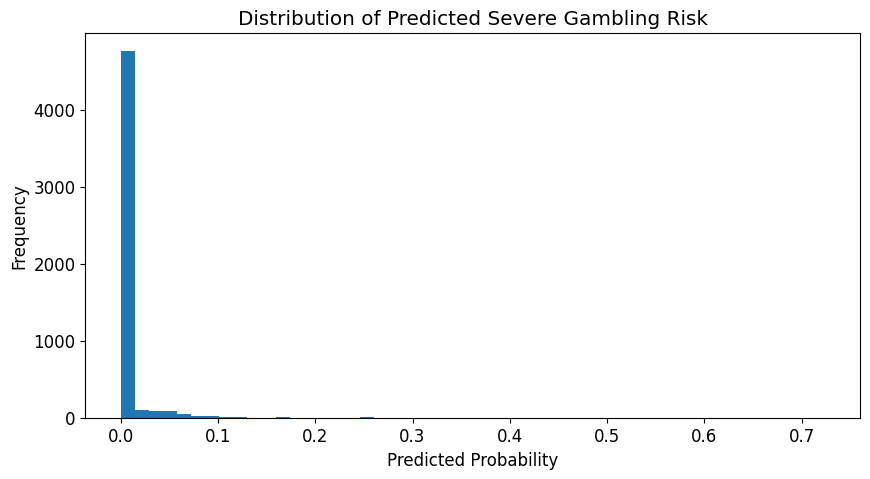

,Predicted_Risk,Actual
10761,0.000012,0
13492,0.000013,0
14113,0.000014,0
17669,0.000014,0
8000,0.000014,0
...,...,...
18770,0.553525,0
22810,0.584811,0
25026,0.590402,1
20857,0.607961,1


In [ ]:
# TOP 20 HIGH-RISK INDIVIDUALS
top20_idx = np.argsort(probabilities)
top20 = pd.DataFrame({
    "Predicted_Risk": probabilities[top20_idx],
    "Actual": y_test.iloc[top20_idx]
})


import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(probabilities, bins=50)
plt.title("Distribution of Predicted Severe Gambling Risk")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


top20

WHAT ARE THE TOP PREDICTORS OF SEVERE GAMBLING?

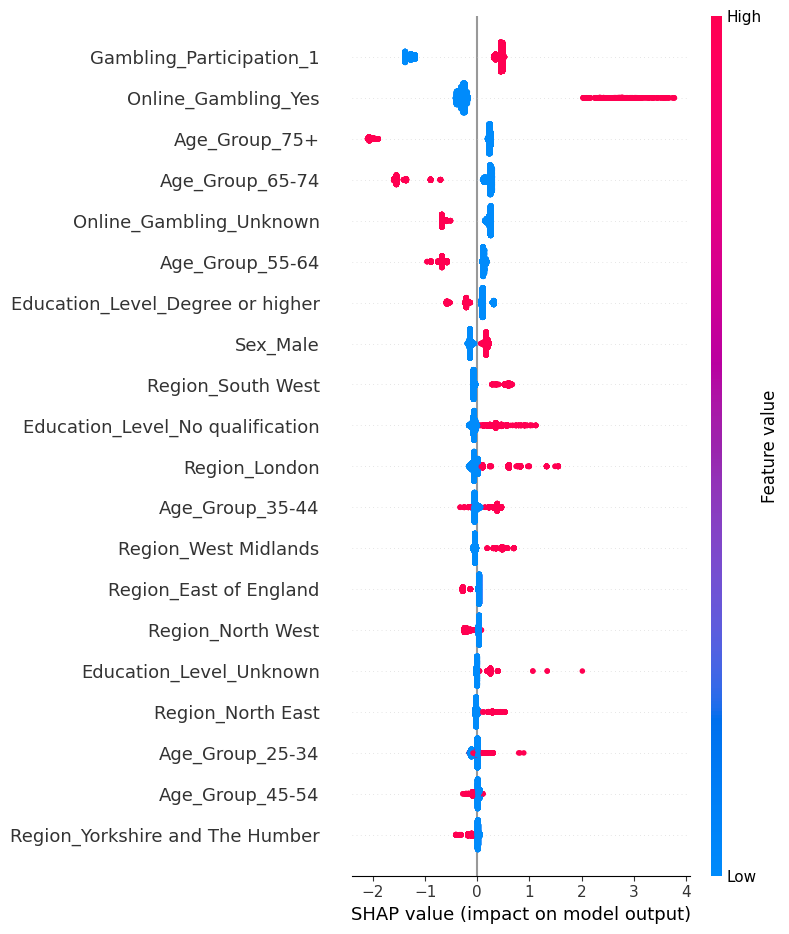

In [ ]:
#Create SHAP explainer
explainer = shap.TreeExplainer(loaded_model)

#Compute SHAP values for test data
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(
    shap_values,
    X_test_scaled,
    feature_names=X.columns
)


In [ ]:
import pandas as pd
import numpy as np

shap_importance = np.abs(shap_values).mean(axis=0)

shap_ranking = (
    pd.DataFrame({
        "Feature": X.columns,
        "Mean |SHAP value|": shap_importance
    })
    .sort_values("Mean |SHAP value|", ascending=False)
)

shap_ranking.head(10)


,Feature,Mean |SHAP value|
22,Gambling_Participation_1,0.663687
21,Online_Gambling_Yes,0.493812
7,Age_Group_75+,0.439799
6,Age_Group_65-74,0.430064
20,Online_Gambling_Unknown,0.344084
5,Age_Group_55-64,0.211903
9,Education_Level_Degree or higher,0.166302
0,Sex_Male,0.151188
17,Region_South West,0.123014
10,Education_Level_No qualification,0.114972


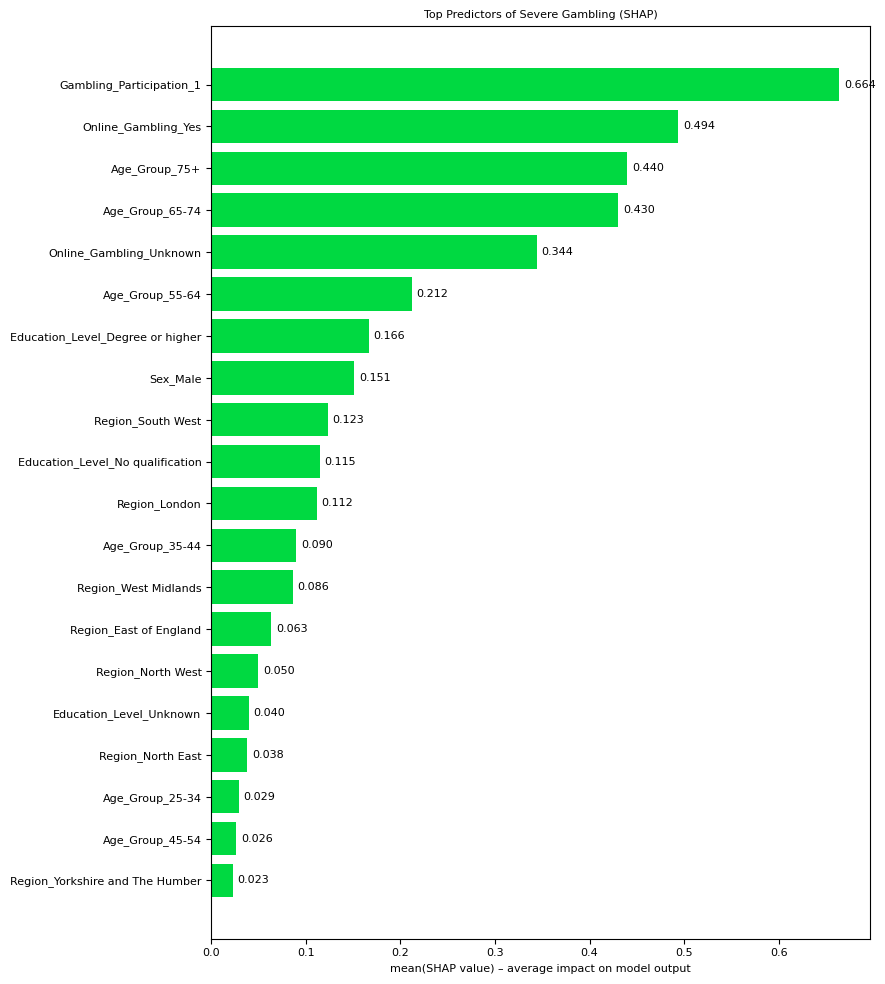

In [ ]:
# Convert SHAP values to numpy if needed
if hasattr(shap_values, "values"):
    shap_array = shap_values.values
else:
    shap_array = shap_values

# Mean absolute SHAP values
mean_abs_shap = np.abs(shap_array).mean(axis=0)

# Create DataFrame
shap_importance = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": mean_abs_shap
})

# Sort and keep top N features (reduce clutter)
TOP_N = 20
shap_importance = (
    shap_importance
    .sort_values("mean_abs_shap", ascending=False)
    .head(TOP_N)
)



fig, ax = plt.subplots(figsize=(9, 10))  # wider figure → longer bars

bars = ax.barh(
    shap_importance["feature"],
    shap_importance["mean_abs_shap"],
    color="#00D941FF"
)

# Add value labels at end of bars
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.005,  # small offset
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va="center",
        fontsize=8
    )

# Axis formatting
ax.invert_yaxis()
ax.set_xlabel(
    "mean(SHAP value) – average impact on model output",
    fontsize=8
)

ax.set_title(
    "Top Predictors of Severe Gambling (SHAP)",
    fontsize=8
)

# Tick label size (same everywhere)
ax.tick_params(axis="both", labelsize=8)

plt.tight_layout()
plt.show()


In [ ]:
X_test_scaled
#save the X_test_scaled
import joblib
joblib.dump(X_test_scaled, r"C:\Users\Admin\Documents\gambling project\dataset\processed\X_test_scaled.pkl")


X = df_encoded.drop("severe_gambler", axis=1)
#save the X
joblib.dump(X, r"C:\Users\Admin\Documents\gambling project\dataset\processed\X.pkl")



['C:\\Users\\Admin\\Documents\\gambling project\\dataset\\processed\\X.pkl']